# **Subtask C**

In [ ]:
import spacy
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from sklearn import preprocessing, linear_model, model_selection, neighbors, svm, naive_bayes, metrics, tree
from spacy import displacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# instantiates the spacy language module
nlp = spacy.load("en_core_web_sm")

In [ ]:
# call and display the dataframe
tweets_df = pd.read_csv('drive/My Drive/OLIDv1.0/olid-training-v1.0.tsv', delimiter="\t")
tweets_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [ ]:
# size of the dataset
len(tweets_df)

13240

In [ ]:
# changes the dataframe index to the tweet id
tweets_df = tweets_df.set_index('id')

In [ ]:
# display information about the dataframe
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13240 entries, 86426 to 46552
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet      13240 non-null  object
 1   subtask_a  13240 non-null  object
 2   subtask_b  4400 non-null   object
 3   subtask_c  3876 non-null   object
dtypes: object(4)
memory usage: 517.2+ KB


In [ ]:
# storing dtype before operation 
dtype_before = type(tweets_df["tweet"]) 
  
# converting to list 
tweet_list = tweets_df["tweet"].tolist() 
  
# storing dtype after operation 
dtype_after = type(tweet_list) 

# stores the tweets in a list
doc = nlp(tweet_list[0])

In [ ]:
# shows the first tweet in the list
doc

@USER She should ask a few native Americans what their take on this is.

In [ ]:
# shows the tweet split up into indivdual sections
[token.text for token in doc]

['@USER',
 'She',
 'should',
 'ask',
 'a',
 'few',
 'native',
 'Americans',
 'what',
 'their',
 'take',
 'on',
 'this',
 'is',
 '.']

**Pre-processing the Dataset**

In [ ]:
tweets_df.drop(['subtask_a', 'subtask_b'], axis = 1, inplace = True, errors = 'ignore')
tweets_df.head()

,tweet,subtask_c
id,,
86426,@USER She should ask a few native Americans wh...,NaN
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,IND
16820,Amazon is investigating Chinese employees who ...,NaN
62688,"@USER Someone should'veTaken"" this piece of sh...",NaN
43605,@USER @USER Obama wanted liberals &amp; illega...,NaN


In [ ]:
tweets_df = tweets_df.dropna()

In [ ]:
tweets_df.head()

,tweet,subtask_c
id,,
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,IND
97670,@USER Liberals are all Kookoo !!!,OTH
52415,@USER was literally just talking about this lo...,GRP
13384,@USER Canada doesn’t need another CUCK! We alr...,IND
28414,@USER you are a lying corrupt traitor!!! Nobod...,IND


In [ ]:
le = LabelEncoder()
tweets_df['subtask_c'] = le.fit_transform(tweets_df['subtask_c']) 
tweets_df.head()

#1=individual
#2=other
#3=group

,tweet,subtask_c
id,,
90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,1
97670,@USER Liberals are all Kookoo !!!,2
52415,@USER was literally just talking about this lo...,0
13384,@USER Canada doesn’t need another CUCK! We alr...,1
28414,@USER you are a lying corrupt traitor!!! Nobod...,1


In [ ]:
# method that will remove @USER tags from the data
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)

  return input_txt

# tags are removed and a new dataset without them is saved
tweets_df['tweet'] = np.vectorize(remove_pattern)(tweets_df['tweet'], "@[\w]*")

# URL links had been changes to 'URL' so they have been removed as they're unnecessary
tweets_df['tweet'] = np.vectorize(remove_pattern)(tweets_df['tweet'], "URL")

In [ ]:
# removes useless emoticons and punctuation
tweets_df['tweet'] = tweets_df['tweet'].str.replace("[^a-zA-Z#']", " " )

In [ ]:
# displays the processed data without tags, URL or useless punctuation
tweets_df.head()

,tweet,subtask_c
id,,
90194,Go home you re drunk #MAGA #Trump,1
97670,Liberals are all Kookoo,2
52415,was literally just talking about this lol all...,0
13384,Canada doesn t need another CUCK We already ...,1
28414,you are a lying corrupt traitor Nobody wan...,1


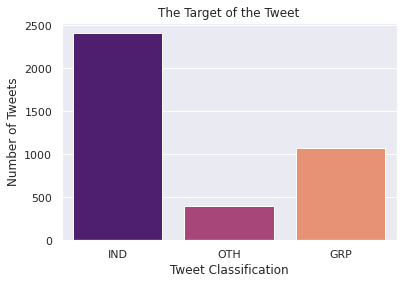

In [ ]:
barData = pd.read_csv('drive/My Drive/OLIDv1.0/olid-training-v1.0.tsv', delimiter="\t")
sns.countplot(x = 'subtask_c',  data = barData, palette = 'magma')
plt.ylabel('Number of Tweets')
plt.xlabel('Tweet Classification')
plt.title('The Target of the Tweet')
plt.show()

**Machine Learning using the Bag-of-Words Method**

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
# create a count vector to extract the words as bag-of-words
bow_vect = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# transform the tweets into the vectorisation
bow = bow_vect.fit_transform(tweets_df['tweet'])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score

# create the training and testing bag-of-words
train_bow = bow[:13240, :] #31962
test_bow = bow[13240:, :]

# set up a training and testing split 
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, tweets_df['subtask_c'], random_state=42, test_size=0.2)

# instantiate the logistic regression function
lreg = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999)
lreg.fit(xtrain_bow, ytrain)

# set up the predictions
prediction = lreg.predict_proba(xvalid_bow)
prediction_int = prediction[:,2] >= 0.3
prediction_int = prediction_int.astype(np.int)

In [ ]:
# calculate the baseline accuracy
baseline_predictions = [1 for x in yvalid]
metrics.accuracy_score(yvalid, baseline_predictions)

0.645618556701031

In [ ]:
# display the logistic regression f1 prediction
f1_score(yvalid, prediction_int, average='macro')

0.15697186382714132

In [ ]:
# prediction accuracy
metrics.accuracy_score(yvalid, prediction_int)

0.25902061855670105

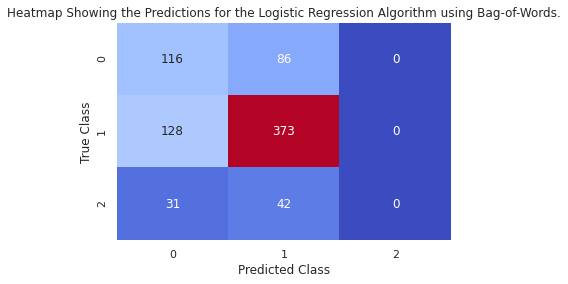

In [ ]:
# set up a heatmap to visualise the predictions of the logistic regression algorithm
cm = metrics.confusion_matrix(yvalid, prediction_int)#, labels = [1,0,2])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',cbar=False, ax=ax)
#ax.set_xticklabels(['Group','Individual', 'Other'])
#ax.set_yticklabels(['Group','Individual', 'Other'])
ax.set_xlabel('Predicted Class')
ax.set_title('Heatmap Showing the Predictions for the Logistic Regression Algorithm using Bag-of-Words.')
# I had to offset the ylim because matplotlib's newest update has caused them to go wonky otherwise
#ax.set_ylim([0,2])
ax.set_ylabel('True Class');

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
accuracies_bow = []
f1_bow = []
macro_bow = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(xtrain_bow, ytrain)
    prediction = clf.predict_proba(xvalid_bow)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc = metrics.accuracy_score(yvalid, prediction_int)
    accuracies_bow.append(acc)
    f1 = f1_score(yvalid, prediction_int, average='weighted')
    f1_bow.append(f1)
    macro = f1_score(yvalid, prediction_int, average='macro')
    macro_bow.append(macro)
# save the accuracies in a DataFrame
models_bow = pd.DataFrame({'Model':classifier_names, 'Accuracy Baseline':accuracies_bow})

In [ ]:
# save the f1 scores to a dataframe
models_bow_f1 = pd.DataFrame({'Model':classifier_names, 'F1 Baseline':f1_bow})

**Machine Learning using the TF-IDF Method**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# create a count vector to extract the words as TF-IDF
tfidf_vect = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# transform the tweets into the vectorisation
tfidf = tfidf_vect.fit_transform(tweets_df['tweet'])

In [ ]:
# create the training and testing tfidf sets
train_tfidf = tfidf[:13240, :] #31962
test_tfidf = tfidf[13240:, :]

# set up a training and testing split 
xtrain_tfidf, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(train_tfidf, tweets_df['subtask_c'], random_state=42, test_size=0.2)

# instantiate the logistic regression function
lreg = LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999)
lreg.fit(xtrain_tfidf, ytrain_tfidf)

# set up the predictions
prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)

In [ ]:
# display the model accuracy
metrics.accuracy_score(yvalid_tfidf, prediction_int)

0.6829896907216495

In [ ]:
# display the logistic regression f1 prediction
f1_score(yvalid_tfidf, prediction_int, average='macro')

0.37951072183630324

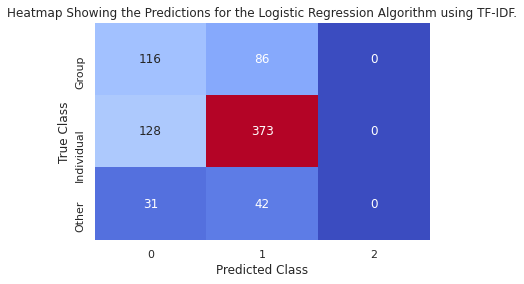

In [ ]:
# set up a heatmap to visualise the predictions of the logistic regression algorithm
cm = metrics.confusion_matrix(yvalid_tfidf, prediction_int)#, labels = [1,0,2])
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm',cbar=False, ax=ax)
##ax.set_xticklabels(['Group','Individual', 'Other'])
ax.set_yticklabels(['Group','Individual', 'Other'])
ax.set_xlabel('Predicted Class')
ax.set_title('Heatmap Showing the Predictions for the Logistic Regression Algorithm using TF-IDF.')
# I had to offset the ylim because matplotlib's newest update has caused them to go wonky otherwise
#ax.set_ylim([0,2])
ax.set_ylabel('True Class');

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
accuracies_tfidf = []
tfidf_f1 = []
tfidf_macro = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(xtrain_tfidf, ytrain_tfidf)
    prediction = clf.predict_proba(xvalid_tfidf)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc = metrics.accuracy_score(yvalid_tfidf, prediction_int)
    accuracies_tfidf.append(acc)
    f1 = f1_score(yvalid_tfidf, prediction_int, average='weighted')
    tfidf_f1.append(f1)
    macro = f1_score(yvalid_tfidf, prediction_int, average='macro')
    tfidf_macro.append(macro)
# save the accuracies in a DataFrame
models_tfidf = pd.DataFrame({'Model':classifier_names, 'Accuracy Baseline':accuracies_tfidf}) 

In [ ]:
# f1 scores
models_tfidf = pd.DataFrame({'Model':classifier_names, 'F1 Baseline':tfidf_f1}) 

In [ ]:
# accuracies of the algorithms for the two methods
models = pd.DataFrame({'Model':classifier_names, 'Bag-of-Words Accuracy':accuracies_bow, 'TF-IDF Accuracy':accuracies_tfidf}) 

In [ ]:
models_all = pd.DataFrame({'Model':classifier_names, 'BoW Accuracy': accuracies_bow, 'TF-IDF Accuracy': accuracies_tfidf, 'BoW F1':f1_bow, 'TF-IDF F1':tfidf_f1, 'BoW Macro F1':macro_bow, 'TF-IDF Macro F1':tfidf_macro})

# comparison between the f1 scores and accuracies of all algorithms between the two methods
models_all

,Model,BoW Accuracy,TF-IDF Accuracy,BoW F1,TF-IDF F1,BoW Macro F1,TF-IDF Macro F1
0,KNN,0.668814,0.643041,0.610041,0.515708,0.389872,0.273628
1,Multinomial NB,0.688144,0.657216,0.646585,0.543387,0.430723,0.305198
2,Logistic,0.704897,0.682990,0.654518,0.606154,0.435389,0.379511
3,Decision Tree,0.635309,0.641753,0.613126,0.617136,0.415820,0.417035
4,SGD,0.682990,0.695876,0.643329,0.640886,0.430353,0.421315
5,MLP,0.640464,0.630155,0.616888,0.607278,0.415234,0.410295


**Maximum Absolute Scaling of the Bag-of-Words Data**

In [ ]:
scalerminmax = preprocessing.MaxAbsScaler()
scalerminmax.fit(xtrain_bow)
X_train_scaled_minmax_bow = scalerminmax.transform(xtrain_bow)
X_train_scaled_minmax_bow[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
X_valid_scaled_normal_bow = scalerminmax.transform(xvalid_bow)
accuracies_bow_normal = []
f1_bow_normal = []
macro_bow_normal = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(X_train_scaled_minmax_bow, ytrain)
    prediction = clf.predict_proba(X_valid_scaled_normal_bow)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc_bow_max = metrics.accuracy_score(yvalid, prediction_int)
    accuracies_bow_normal.append(acc_bow_max)
    f1_bow_max = f1_score(yvalid, prediction_int, average='weighted')
    f1_bow_normal.append(f1_bow_max)
    macro_bow_norm = f1_score(yvalid, prediction_int, average='macro')
    macro_bow_normal.append(macro_bow_norm)
# save the accuracies in a DataFrame
models_bow_normal = pd.DataFrame({'model':classifier_names, 'MaxAbScaled':accuracies_bow_normal})    
#models_bow_normal

**Standardisation of the Bag-of-Words Data**

In [ ]:
# scale the data using standardisation
scaler = preprocessing.StandardScaler(with_mean=False)
scaler.fit(xtrain_bow)
# transform and scale the data
X_train_standard_bow = scaler.transform(xtrain_bow)
X_train_standard_bow[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
X_valid_scaled_standard_bow = scaler.transform(xvalid_bow)
accuracies_bow_standard = []
f1_bow_standard = []
macro_bow_standard = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(X_train_standard_bow, ytrain)
    prediction = clf.predict_proba(X_valid_scaled_standard_bow)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc_bow_stan = metrics.accuracy_score(yvalid, prediction_int)
    accuracies_bow_standard.append(acc_bow_stan)
    f1_bow_stan = f1_score(yvalid, prediction_int, average='weighted')
    f1_bow_standard.append(f1_bow_stan)
    macro_bow_stan = f1_score(yvalid, prediction_int, average='macro')
    macro_bow_standard.append(macro_bow_stan)
# save the accuracies in a DataFrame
models_tfidf_bow = pd.DataFrame({'model':classifier_names, 'standard':accuracies_bow_standard})    
#models_tfidf_bow

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


**Maximum Absolute Scaling of the TF-IDF Data**

In [ ]:
# scale the training data with maximum absolute scaling
scalerminmax = preprocessing.MaxAbsScaler()
scalerminmax.fit(xtrain_tfidf)
# transfrom and scale the data
X_train_scaled_minmax_tfidf = scalerminmax.transform(xtrain_tfidf)
X_train_scaled_minmax_tfidf[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
X_valid_scaled_normal_tfidf = scalerminmax.transform(xvalid_tfidf)
accuracies_tfidf_normal = []
f1_tfidf_normal = []
macro_tfidf_normal = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(X_train_scaled_minmax_tfidf, ytrain_tfidf)
    # find the results
    prediction = clf.predict_proba(X_valid_scaled_normal_tfidf)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc_tfidf_max = metrics.accuracy_score(yvalid_tfidf, prediction_int)
    accuracies_tfidf_normal.append(acc_tfidf_max)
    f1_tfidf_max = f1_score(yvalid_tfidf, prediction_int, average='weighted')
    f1_tfidf_normal.append(f1_tfidf_max)
    macro_tfidf_norm = f1_score(yvalid_tfidf, prediction_int, average='macro')
    macro_tfidf_normal.append(macro_tfidf_norm)
# save the accuracies in a DataFrame
models_tfidf_normal = pd.DataFrame({'model':classifier_names, 'MaxAbScaled':accuracies_tfidf_normal})    
#models_tfidf_normal

**Standardisation of the TF-IDF Data**

In [ ]:
scaler = preprocessing.StandardScaler(with_mean=False)
scaler.fit(xtrain_tfidf)
X_train_standard = scaler.transform(xtrain_tfidf)
X_train_standard[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
# instantiate some machine learning functions
classifiers = [neighbors.KNeighborsClassifier(),
               naive_bayes.MultinomialNB(),
               linear_model.LogisticRegression(solver='lbfgs', multi_class='ovr', max_iter=9999),
               tree.DecisionTreeClassifier(),
               linear_model.SGDClassifier(loss="log", penalty="l2", max_iter=50),
               MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
               learning_rate_init=0.001, max_iter=500, momentum=0.9,
               nesterovs_momentum=True, power_t=0.5, random_state=None,
               shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
               verbose=False, warm_start=False)]

classifier_names = ['KNN','Multinomial NB','Logistic', 'Decision Tree', 'SGD', 'MLP']
X_valid_scaled_standard_tfidf = scaler.transform(xvalid_tfidf)
accuracies_tfidf_standard = []
f1_tfidf_standard = []
macro_tfidf_standard = []
# iterate through the loop, training and fitting the tweet data
for clf, name in zip(classifiers,classifier_names):
    clf.fit(X_train_standard, ytrain_tfidf)
    prediction = clf.predict_proba(X_valid_scaled_standard_tfidf)
    prediction_int = prediction[:,1] >= 0.3
    prediction_int = prediction_int.astype(np.int)
    acc_tfidf_stan = metrics.accuracy_score(yvalid_tfidf, prediction_int)
    accuracies_tfidf_standard.append(acc_tfidf_stan)
    f1_tfidf_stan = f1_score(yvalid_tfidf, prediction_int, average='weighted')
    f1_tfidf_standard.append(f1_tfidf_stan)
    macro_tfidf_stan = f1_score(yvalid_tfidf, prediction_int, average='macro')
    macro_tfidf_standard.append(macro_tfidf_stan)
# save the accuracies in a DataFrame
models_tfidf_standard = pd.DataFrame({'model':classifier_names, 'standard':accuracies_tfidf_standard})    
#models_tfidf_standard

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_stochastic_gradient.py:557: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


**Accuracy Scores for the Default and Scaled Algorithms**

In [ ]:
# data frame showing all the scaled and unscaled algorithm results
models_acc = pd.DataFrame({'Model':classifier_names, 
                       'Bag-of-Words':accuracies_bow, 
                       'BoW MaxAbScaled': accuracies_bow_normal, 
                       'BoW Standardised':accuracies_bow_standard, 
                       'TF-IDF':accuracies_tfidf, 
                       'TF-IDF MaxAbScaled':accuracies_tfidf_normal, 
                       'TF-IDF Standardised':accuracies_tfidf_standard})    
models_acc

,Model,Bag-of-Words,BoW MaxAbScaled,BoW Standardised,TF-IDF,TF-IDF MaxAbScaled,TF-IDF Standardised
0,KNN,0.668814,0.657216,0.653351,0.643041,0.643041,0.645619
1,Multinomial NB,0.688144,0.680412,0.560567,0.657216,0.676546,0.554124
2,Logistic,0.704897,0.692010,0.655928,0.682990,0.688144,0.643041
3,Decision Tree,0.627577,0.630155,0.644330,0.645619,0.648196,0.637887
4,SGD,0.686856,0.688144,0.621134,0.695876,0.685567,0.635309
5,MLP,0.648196,0.632732,0.614691,0.614691,0.614691,0.619845


**Weighted F1 Scores for the Default and Scaled Algorithms**

In [ ]:
# data frame showing all the scaled and unscaled algorithm results
models_f1 = pd.DataFrame({'Model':classifier_names, 
                       'Bag-of-Words':f1_bow, 
                       'BoW MaxAbScaled': f1_bow_normal, 
                       'BoW Standardised':f1_bow_standard, 
                       'TF-IDF':tfidf_f1, 
                       'TF-IDF MaxAbScaled':f1_tfidf_normal, 
                       'TF-IDF Standardised':f1_tfidf_standard})    
models_f1

,Model,Bag-of-Words,BoW MaxAbScaled,BoW Standardised,TF-IDF,TF-IDF MaxAbScaled,TF-IDF Standardised
0,KNN,0.610041,0.573761,0.554245,0.515708,0.515708,0.523214
1,Multinomial NB,0.646585,0.617252,0.554533,0.543387,0.607205,0.547608
2,Logistic,0.654518,0.632938,0.625895,0.606154,0.619230,0.613949
3,Decision Tree,0.606687,0.608160,0.620688,0.619478,0.623102,0.613591
4,SGD,0.646606,0.639825,0.601698,0.640234,0.635136,0.612481
5,MLP,0.624970,0.610320,0.592364,0.592020,0.593699,0.596361


**Macro F1 Scores for the Default and Scaled Algorithms**

In [ ]:
# data frame showing all the scaled and unscaled algorithm results
models_macro_f1 = pd.DataFrame({'Model':classifier_names, 
                        'Bag-of-Words':macro_bow, 
                        'BoW MaxAbScaled': macro_bow_normal, 
                        'BoW Standardised':macro_bow_standard, 
                        'TF-IDF':tfidf_macro, 
                        'TF-IDF MaxAbScaled':macro_tfidf_normal, 
                        'TF-IDF Standardised':macro_tfidf_standard})    
models_macro_f1

,Model,Bag-of-Words,BoW MaxAbScaled,BoW Standardised,TF-IDF,TF-IDF MaxAbScaled,TF-IDF Standardised
0,KNN,0.389872,0.346522,0.321884,0.273628,0.273628,0.282795
1,Multinomial NB,0.430723,0.394168,0.376390,0.305198,0.381822,0.373401
2,Logistic,0.435389,0.411866,0.421938,0.379511,0.394395,0.411025
3,Decision Tree,0.408820,0.410572,0.421798,0.416921,0.420537,0.412864
4,SGD,0.433821,0.423366,0.406723,0.420317,0.416844,0.415485
5,MLP,0.422348,0.413338,0.394724,0.396240,0.399611,0.397743


**Parameter-Tuning for the TF-IDF Logistic Regression Algorithm**

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for c in range(1,30):
    for solver in ['saga', 'newton-cg','lbfgs','sag']:
        for multiclass in ['ovr', 'multinomial', 'auto']:
                clf = linear_model.LogisticRegression(solver=solver, C=c, multi_class=multiclass, max_iter=9999)
                clf.fit(xtrain_tfidf, ytrain_tfidf)
                # set up the predictions
                prediction = clf.predict_proba(xvalid_tfidf)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid_tfidf, prediction_int)
                f1 = f1_score(yvalid_tfidf, prediction_int, average='weighted')
                macro = f1_score(yvalid_tfidf, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_c = c
                    best_solver = solver
                    best_multiclass = multiclass
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_c)+' C, the '+str(best_solver)+' solver and using the multi class, '+str(best_multiclass))

Best Accuracy was 0.7010309278350515, the best Macro F1 was 0.431179180547832 and the best F1 was 0.6502724759167118 using 5 C, the saga solver and using the multi class, ovr


**Parameter Tuning for the Bag-of-Words Logistic Regression Algorithm**

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for c in range(1,30):
    for solver in ['saga', 'newton-cg','lbfgs','sag']:
        for multiclass in ['ovr', 'multinomial', 'auto']:
                clf = linear_model.LogisticRegression(solver=solver, C=c, multi_class=multiclass, max_iter=9999)
                clf.fit(xtrain_bow, ytrain)
                # set up the predictions
                prediction = clf.predict_proba(xvalid_bow)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid, prediction_int)
                f1 = f1_score(yvalid, prediction_int, average='weighted')
                macro = f1_score(yvalid, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_c = c
                    best_solver = solver
                    best_multiclass = multiclass
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_c)+' C, the '+str(best_solver)+' solver and using the multi class, '+str(best_multiclass))

Best Accuracy was 0.7087628865979382, the best Macro F1 was 0.4418019323671498 and the best F1 was 0.6587512647324236 using 1 C, the saga solver and using the multi class, multinomial


**Parameter Tuning for the TF-IDF SGD**

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for v in range(1,30):
    for penalty in ['l2', 'l1','elasticnet']:
        for lr in ['optimal']:
                clf = linear_model.SGDClassifier(loss='log', penalty=penalty, verbose=v, learning_rate=lr, max_iter=9999, shuffle=True)
                clf.fit(xtrain_tfidf, ytrain_tfidf)
                # set up the predictions
                prediction = clf.predict_proba(xvalid_tfidf)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid_tfidf, prediction_int)
                f1 = f1_score(yvalid_tfidf, prediction_int, average='weighted')
                macro = f1_score(yvalid_tfidf, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_v = v
                    best_penalty = penalty
                    best_lr = lr
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_v)+' verbose, the '+str(best_penalty)+' penalty and using the learning rate, '+str(best_lr))

-- Epoch 1
Norm: 40.86, NNZs: 1000, Bias: -2.000977, T: 3100, Avg. loss: 0.629379
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 35.90, NNZs: 1000, Bias: -2.093127, T: 6200, Avg. loss: 0.437641
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 34.33, NNZs: 1000, Bias: -2.057491, T: 9300, Avg. loss: 0.400729
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 34.30, NNZs: 1000, Bias: -1.943438, T: 12400, Avg. loss: 0.385643
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 33.75, NNZs: 1000, Bias: -2.013702, T: 15500, Avg. loss: 0.379326
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 33.40, NNZs: 1000, Bias: -2.018344, T: 18600, Avg. loss: 0.373497
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 32.96, NNZs: 1000, Bias: -2.069777, T: 21700, Avg. loss: 0.369215
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 32.95, NNZs: 1000, Bias: -2.044471, T: 24800, Avg. loss: 0.367772
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 32.96, NNZs: 1000, Bias: -2.022003, T: 279

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 8
Norm: 36.31, NNZs: 879, Bias: -2.064258, T: 24800, Avg. loss: 0.363947
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 36.12, NNZs: 882, Bias: -2.059643, T: 27900, Avg. loss: 0.362231
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 35.99, NNZs: 884, Bias: -2.052349, T: 31000, Avg. loss: 0.361258
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 35.84, NNZs: 887, Bias: -2.061360, T: 34100, Avg. loss: 0.359698
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 35.86, NNZs: 892, Bias: -2.038739, T: 37200, Avg. loss: 0.359268
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 35.76, NNZs: 896, Bias: -2.047986, T: 40300, Avg. loss: 0.358204
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 35.65, NNZs: 897, Bias: -2.049203, T: 43400, Avg. loss: 0.357286
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 35.61, NNZs: 896, Bias: -2.042227, T: 46500, Avg. loss: 0.356851
Total training time: 0.03 seconds.
-- Epoch 16
Norm: 35.50, NNZs: 896, Bias: -2.053483, T: 49

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 36.35, NNZs: 880, Bias: -2.032908, T: 27900, Avg. loss: 0.362587
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 36.13, NNZs: 883, Bias: -2.038654, T: 31000, Avg. loss: 0.360940
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 35.96, NNZs: 885, Bias: -2.051099, T: 34100, Avg. loss: 0.359895
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 35.87, NNZs: 892, Bias: -2.044340, T: 37200, Avg. loss: 0.358720
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 35.77, NNZs: 894, Bias: -2.046357, T: 40300, Avg. loss: 0.357967
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 35.59, NNZs: 893, Bias: -2.064923, T: 43400, Avg. loss: 0.357093
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 35.64, NNZs: 897, Bias: -2.037626, T: 46500, Avg. loss: 0.356721
Total training time: 0.03 seconds.
-- Epoch 16
Norm: 35.54, NNZs: 896, Bias: -2.045429, T: 49600, Avg. loss: 0.356170
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 35.45, NNZs: 897, Bias: -2.055108, T: 52700, Avg. 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


-- Epoch 6
Norm: 81.65, NNZs: 435, Bias: -2.633290, T: 18600, Avg. loss: 0.230068
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 82.81, NNZs: 430, Bias: -2.617272, T: 21700, Avg. loss: 0.227394
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 83.71, NNZs: 429, Bias: -2.674876, T: 24800, Avg. loss: 0.226425
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 84.53, NNZs: 428, Bias: -2.704351, T: 27900, Avg. loss: 0.224887
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 85.27, NNZs: 424, Bias: -2.710949, T: 31000, Avg. loss: 0.223834
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 85.91, NNZs: 419, Bias: -2.723781, T: 34100, Avg. loss: 0.222968
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 86.48, NNZs: 421, Bias: -2.752231, T: 37200, Avg. loss: 0.221877
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 87.03, NNZs: 419, Bias: -2.755369, T: 40300, Avg. loss: 0.221702
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 87.51, NNZs: 419, Bias: -2.771787, T: 4340

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Norm: 93.22, NNZs: 609, Bias: 1.652437, T: 3100, Avg. loss: 0.708494
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 100.50, NNZs: 568, Bias: 1.620460, T: 6200, Avg. loss: 0.435061
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 104.25, NNZs: 572, Bias: 1.630564, T: 9300, Avg. loss: 0.403706
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 107.01, NNZs: 566, Bias: 1.610172, T: 12400, Avg. loss: 0.391398
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 108.98, NNZs: 564, Bias: 1.612141, T: 15500, Avg. loss: 0.384973
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 110.50, NNZs: 562, Bias: 1.665288, T: 18600, Avg. loss: 0.380340
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 111.83, NNZs: 563, Bias: 1.685578, T: 21700, Avg. loss: 0.376997
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 112.98, NNZs: 563, Bias: 1.670481, T: 24800, Avg. loss: 0.375236
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 113.91, NNZs: 564, Bias: 1.714369, T: 27900, Avg. loss: 0.3732

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

Norm: 27.75, NNZs: 1000, Bias: -2.526463, T: 18600, Avg. loss: 0.231285
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 27.56, NNZs: 1000, Bias: -2.570094, T: 21700, Avg. loss: 0.229065
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 27.53, NNZs: 1000, Bias: -2.582940, T: 24800, Avg. loss: 0.227524
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 27.38, NNZs: 1000, Bias: -2.611870, T: 27900, Avg. loss: 0.225757
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 27.40, NNZs: 1000, Bias: -2.602031, T: 31000, Avg. loss: 0.225051
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 27.37, NNZs: 1000, Bias: -2.603927, T: 34100, Avg. loss: 0.224344
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 27.33, NNZs: 1000, Bias: -2.606435, T: 37200, Avg. loss: 0.223547
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 27.31, NNZs: 1000, Bias: -2.610628, T: 40300, Avg. loss: 0.223115
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 27.26, NNZs: 1000, Bias: -2.617352, T: 43400,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


-- Epoch 7
Norm: 33.16, NNZs: 1000, Bias: -2.038843, T: 21700, Avg. loss: 0.369853
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 32.97, NNZs: 1000, Bias: -2.056616, T: 24800, Avg. loss: 0.367255
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 32.96, NNZs: 1000, Bias: -2.034603, T: 27900, Avg. loss: 0.365182
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 32.82, NNZs: 1000, Bias: -2.046723, T: 31000, Avg. loss: 0.363652
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 32.85, NNZs: 1000, Bias: -2.033120, T: 34100, Avg. loss: 0.362688
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 32.74, NNZs: 1000, Bias: -2.046337, T: 37200, Avg. loss: 0.360932
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 32.73, NNZs: 1000, Bias: -2.034803, T: 40300, Avg. loss: 0.360202
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 32.64, NNZs: 1000, Bias: -2.047997, T: 43400, Avg. loss: 0.359290
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 32.65, NNZs: 1000, Bias: -2.03485

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

-- Epoch 16
Norm: 37.73, NNZs: 888, Bias: 1.485005, T: 49600, Avg. loss: 0.390832
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 37.64, NNZs: 888, Bias: 1.493750, T: 52700, Avg. loss: 0.390116
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 37.59, NNZs: 888, Bias: 1.490278, T: 55800, Avg. loss: 0.389606
Total training time: 0.03 seconds.
Convergence after 18 epochs took 0.03 seconds
-- Epoch 1
Norm: 33.29, NNZs: 874, Bias: -2.437831, T: 3100, Avg. loss: 0.378998
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 32.28, NNZs: 832, Bias: -2.458729, T: 6200, Avg. loss: 0.264161
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 31.45, NNZs: 839, Bias: -2.560643, T: 9300, Avg. loss: 0.244100
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 31.22, NNZs: 851, Bias: -2.518069, T: 12400, Avg. loss: 0.237065
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 30.85, NNZs: 852, Bias: -2.564465, T: 15500, Avg. loss: 0.232435
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 30.5

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
Norm: 44.46, NNZs: 879, Bias: -1.925888, T: 3100, Avg. loss: 0.605490
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 39.97, NNZs: 842, Bias: -2.013696, T: 6200, Avg. loss: 0.428393
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 38.87, NNZs: 850, Bias: -1.944611, T: 9300, Avg. loss: 0.394378
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 37.60, NNZs: 860, Bias: -2.075474, T: 12400, Avg. loss: 0.381241
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 37.26, NNZs: 864, Bias: -2.051235, T: 15500, Avg. loss: 0.374681
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 36.94, NNZs: 870, Bias: -2.022482, T: 18600, Avg. loss: 0.370895
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 36.56, NNZs: 875, Bias: -2.050614, T: 21700, Avg. loss: 0.366648
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 36.40, NNZs: 883, Bias: -2.030806, T: 24800, Avg. loss: 0.364463
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 36.30, NNZs: 884, Bias: -2.021539, T: 27900, Avg. 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

Total training time: 0.02 seconds.
-- Epoch 16
Norm: 110.56, NNZs: 529, Bias: -2.272380, T: 49600, Avg. loss: 0.341246
Total training time: 0.03 seconds.
Convergence after 16 epochs took 0.03 seconds
-- Epoch 1
Norm: 90.04, NNZs: 632, Bias: 1.466791, T: 3100, Avg. loss: 0.724846
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 97.57, NNZs: 581, Bias: 1.436129, T: 6200, Avg. loss: 0.442747
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 101.53, NNZs: 572, Bias: 1.600970, T: 9300, Avg. loss: 0.409651
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 104.23, NNZs: 572, Bias: 1.668855, T: 12400, Avg. loss: 0.394557
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 106.43, NNZs: 568, Bias: 1.603036, T: 15500, Avg. loss: 0.388333
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 108.04, NNZs: 566, Bias: 1.635677, T: 18600, Avg. loss: 0.382788
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 109.36, NNZs: 562, Bias: 1.656426, T: 21700, Avg. loss: 0.379559
Total training time: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Norm: 34.49, NNZs: 1000, Bias: 1.459606, T: 49600, Avg. loss: 0.393588
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 34.46, NNZs: 1000, Bias: 1.460790, T: 52700, Avg. loss: 0.393027
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 34.41, NNZs: 1000, Bias: 1.465581, T: 55800, Avg. loss: 0.392626
Total training time: 0.02 seconds.
Convergence after 18 epochs took 0.02 seconds
-- Epoch 1
Norm: 30.00, NNZs: 1000, Bias: -2.334414, T: 3100, Avg. loss: 0.380145
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 28.31, NNZs: 1000, Bias: -2.459019, T: 6200, Avg. loss: 0.270852
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 28.01, NNZs: 1000, Bias: -2.483633, T: 9300, Avg. loss: 0.250806
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 27.66, NNZs: 1000, Bias: -2.554670, T: 12400, Avg. loss: 0.239748
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 27.62, NNZs: 1000, Bias: -2.537765, T: 15500, Avg. loss: 0.235206
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 27.58, N

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

-- Epoch 13
Norm: 32.57, NNZs: 1000, Bias: -2.045421, T: 40300, Avg. loss: 0.360359
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 32.60, NNZs: 1000, Bias: -2.030094, T: 43400, Avg. loss: 0.359840
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 32.60, NNZs: 1000, Bias: -2.029597, T: 46500, Avg. loss: 0.358906
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 32.55, NNZs: 1000, Bias: -2.035704, T: 49600, Avg. loss: 0.358373
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 32.54, NNZs: 1000, Bias: -2.028897, T: 52700, Avg. loss: 0.357851
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 32.55, NNZs: 1000, Bias: -2.022835, T: 55800, Avg. loss: 0.357322
Total training time: 0.02 seconds.
Convergence after 18 epochs took 0.02 seconds
-- Epoch 1
Norm: 42.34, NNZs: 1000, Bias: 1.560681, T: 3100, Avg. loss: 0.692647
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 38.33, NNZs: 1000, Bias: 1.403479, T: 6200, Avg. loss: 0.477780
Total training time: 0.00 seconds.
-- Epoch

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

Convergence after 18 epochs took 0.03 seconds
-- Epoch 1
Norm: 34.69, NNZs: 862, Bias: -2.184029, T: 3100, Avg. loss: 0.377205
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 32.55, NNZs: 818, Bias: -2.433592, T: 6200, Avg. loss: 0.265504
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 31.86, NNZs: 839, Bias: -2.448141, T: 9300, Avg. loss: 0.243409
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 31.24, NNZs: 844, Bias: -2.517212, T: 12400, Avg. loss: 0.236542
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 30.98, NNZs: 846, Bias: -2.500403, T: 15500, Avg. loss: 0.232907
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 30.70, NNZs: 846, Bias: -2.533341, T: 18600, Avg. loss: 0.229475
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 30.41, NNZs: 850, Bias: -2.569353, T: 21700, Avg. loss: 0.227610
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 30.29, NNZs: 855, Bias: -2.575629, T: 24800, Avg. loss: 0.226319
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 30.1

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Total training time: 0.02 seconds.
-- Epoch 14
Norm: 35.69, NNZs: 886, Bias: -2.055022, T: 43400, Avg. loss: 0.357348
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 35.67, NNZs: 890, Bias: -2.042917, T: 46500, Avg. loss: 0.356680
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 35.54, NNZs: 892, Bias: -2.061413, T: 49600, Avg. loss: 0.356008
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 35.45, NNZs: 895, Bias: -2.066701, T: 52700, Avg. loss: 0.355612
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 35.45, NNZs: 894, Bias: -2.055001, T: 55800, Avg. loss: 0.355172
Total training time: 0.03 seconds.
Convergence after 18 epochs took 0.03 seconds
-- Epoch 1
Norm: 48.25, NNZs: 898, Bias: 1.299155, T: 3100, Avg. loss: 0.687781
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 42.92, NNZs: 849, Bias: 1.461682, T: 6200, Avg. loss: 0.468470
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 41.22, NNZs: 852, Bias: 1.490012, T: 9300, Avg. loss: 0.430197
Total training time

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

-- Epoch 12
Norm: 86.70, NNZs: 408, Bias: -2.764213, T: 37200, Avg. loss: 0.220755
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 87.24, NNZs: 409, Bias: -2.773254, T: 40300, Avg. loss: 0.220320
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 87.74, NNZs: 408, Bias: -2.775725, T: 43400, Avg. loss: 0.219863
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 88.21, NNZs: 408, Bias: -2.777644, T: 46500, Avg. loss: 0.219437
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 88.62, NNZs: 407, Bias: -2.790044, T: 49600, Avg. loss: 0.219049
Total training time: 0.02 seconds.
Convergence after 16 epochs took 0.02 seconds
-- Epoch 1
Norm: 44.60, NNZs: 879, Bias: -1.803816, T: 3100, Avg. loss: 0.631655
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 40.87, NNZs: 840, Bias: -1.927181, T: 6200, Avg. loss: 0.425805
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 39.08, NNZs: 840, Bias: -1.979594, T: 9300, Avg. loss: 0.395094
Total training time: 0.00 seconds.
-- Epoch 4
Norm:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

Norm: 102.99, NNZs: 525, Bias: -2.217711, T: 18600, Avg. loss: 0.353980
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 104.27, NNZs: 527, Bias: -2.190438, T: 21700, Avg. loss: 0.351547
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 105.31, NNZs: 521, Bias: -2.206524, T: 24800, Avg. loss: 0.348737
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 106.24, NNZs: 520, Bias: -2.218837, T: 27900, Avg. loss: 0.347238
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 107.02, NNZs: 519, Bias: -2.241493, T: 31000, Avg. loss: 0.345739
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 107.79, NNZs: 522, Bias: -2.221456, T: 34100, Avg. loss: 0.344513
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 108.38, NNZs: 527, Bias: -2.262931, T: 37200, Avg. loss: 0.343379
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 109.04, NNZs: 527, Bias: -2.233441, T: 40300, Avg. loss: 0.343047
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 109.58, NNZs: 528, Bias: -2.243658, T: 43400,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


-- Epoch 9
Norm: 27.44, NNZs: 1000, Bias: -2.586017, T: 27900, Avg. loss: 0.225868
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 27.40, NNZs: 1000, Bias: -2.589489, T: 31000, Avg. loss: 0.225088
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 27.39, NNZs: 1000, Bias: -2.587733, T: 34100, Avg. loss: 0.224302
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 27.37, NNZs: 1000, Bias: -2.588699, T: 37200, Avg. loss: 0.223664
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 27.34, NNZs: 1000, Bias: -2.592696, T: 40300, Avg. loss: 0.222864
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 27.34, NNZs: 1000, Bias: -2.594046, T: 43400, Avg. loss: 0.222646
Total training time: 0.02 seconds.
Convergence after 14 epochs took 0.02 seconds
-- Epoch 1
Norm: 85.87, NNZs: 570, Bias: -1.972328, T: 3100, Avg. loss: 0.653911
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 92.45, NNZs: 529, Bias: -2.103375, T: 6200, Avg. loss: 0.406797
Total training time: 0.00 seconds.
-- Epoch 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

-- Epoch 11
Norm: 34.63, NNZs: 1000, Bias: 1.476146, T: 34100, Avg. loss: 0.397992
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 34.58, NNZs: 1000, Bias: 1.467862, T: 37200, Avg. loss: 0.397009
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 34.58, NNZs: 1000, Bias: 1.456209, T: 40300, Avg. loss: 0.395995
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 34.52, NNZs: 1000, Bias: 1.467814, T: 43400, Avg. loss: 0.394977
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 34.45, NNZs: 1000, Bias: 1.474143, T: 46500, Avg. loss: 0.394264
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 34.47, NNZs: 1000, Bias: 1.458773, T: 49600, Avg. loss: 0.393868
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 34.40, NNZs: 1000, Bias: 1.469857, T: 52700, Avg. loss: 0.393119
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 34.41, NNZs: 1000, Bias: 1.463683, T: 55800, Avg. loss: 0.392732
Total training time: 0.02 seconds.
-- Epoch 19
Norm: 34.42, NNZs: 1000, Bias: 1.457618, T: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

-- Epoch 10
Norm: 36.08, NNZs: 877, Bias: -2.059375, T: 31000, Avg. loss: 0.360385
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 36.09, NNZs: 883, Bias: -2.031337, T: 34100, Avg. loss: 0.360109
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 35.85, NNZs: 883, Bias: -2.065243, T: 37200, Avg. loss: 0.358736
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 35.71, NNZs: 885, Bias: -2.071580, T: 40300, Avg. loss: 0.357694
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 35.65, NNZs: 885, Bias: -2.066105, T: 43400, Avg. loss: 0.357140
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 35.63, NNZs: 887, Bias: -2.054716, T: 46500, Avg. loss: 0.356805
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 35.62, NNZs: 891, Bias: -2.038644, T: 49600, Avg. loss: 0.356009
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 35.52, NNZs: 890, Bias: -2.051667, T: 52700, Avg. loss: 0.355737
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 35.42, NNZs: 891, Bias: -2.059362, T: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 87.26, NNZs: 425, Bias: -2.725448, T: 31000, Avg. loss: 0.222222
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 87.90, NNZs: 426, Bias: -2.738015, T: 34100, Avg. loss: 0.221407
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 88.48, NNZs: 422, Bias: -2.751716, T: 37200, Avg. loss: 0.220694
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 89.00, NNZs: 423, Bias: -2.759158, T: 40300, Avg. loss: 0.220206
Total training time: 0.03 seconds.
-- Epoch 14
Norm: 89.48, NNZs: 422, Bias: -2.768070, T: 43400, Avg. loss: 0.219782
Total training time: 0.03 seconds.
Convergence after 14 epochs took 0.03 seconds
-- Epoch 1
Norm: 45.52, NNZs: 868, Bias: -1.907740, T: 3100, Avg. loss: 0.616409
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 40.57, NNZs: 839, Bias: -2.007820, T: 6200, Avg. loss: 0.427656
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 38.75, NNZs: 845, Bias: -2.023605, T: 9300, Avg. loss: 0.394167
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 37.91, NNZs

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

Norm: 91.09, NNZs: 632, Bias: 1.500310, T: 3100, Avg. loss: 0.730411
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 98.32, NNZs: 589, Bias: 1.590887, T: 6200, Avg. loss: 0.445020
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 102.39, NNZs: 577, Bias: 1.636409, T: 9300, Avg. loss: 0.408740
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 104.98, NNZs: 572, Bias: 1.668725, T: 12400, Avg. loss: 0.394564
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 107.04, NNZs: 567, Bias: 1.686875, T: 15500, Avg. loss: 0.386866
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 108.77, NNZs: 567, Bias: 1.636847, T: 18600, Avg. loss: 0.382215
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 110.16, NNZs: 565, Bias: 1.627886, T: 21700, Avg. loss: 0.379551
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 111.23, NNZs: 563, Bias: 1.685841, T: 24800, Avg. loss: 0.376786
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 112.25, NNZs: 559, Bias: 1.678215, T: 27900, Avg. loss: 0.37466

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

-- Epoch 14
Norm: 108.66, NNZs: 534, Bias: -2.266330, T: 43400, Avg. loss: 0.341953
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 109.19, NNZs: 534, Bias: -2.264924, T: 46500, Avg. loss: 0.341136
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 109.65, NNZs: 533, Bias: -2.282497, T: 49600, Avg. loss: 0.340764
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 110.13, NNZs: 532, Bias: -2.264754, T: 52700, Avg. loss: 0.340276
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 110.53, NNZs: 531, Bias: -2.281516, T: 55800, Avg. loss: 0.339815
Total training time: 0.03 seconds.
Convergence after 18 epochs took 0.03 seconds
-- Epoch 1
Norm: 91.90, NNZs: 631, Bias: 1.496090, T: 3100, Avg. loss: 0.718361
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 98.69, NNZs: 598, Bias: 1.606139, T: 6200, Avg. loss: 0.440186
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 102.74, NNZs: 580, Bias: 1.630138, T: 9300, Avg. loss: 0.404695
Total training time: 0.00 seconds.
-- Epoch 4
No

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

-- Epoch 1
Norm: 87.68, NNZs: 571, Bias: -1.980935, T: 3100, Avg. loss: 0.662360
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 94.57, NNZs: 535, Bias: -2.012268, T: 6200, Avg. loss: 0.404618
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 98.33, NNZs: 525, Bias: -2.056164, T: 9300, Avg. loss: 0.376029
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 100.81, NNZs: 520, Bias: -2.081555, T: 12400, Avg. loss: 0.363475
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 102.63, NNZs: 517, Bias: -2.130761, T: 15500, Avg. loss: 0.357367
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 104.19, NNZs: 515, Bias: -2.128045, T: 18600, Avg. loss: 0.353235
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 105.35, NNZs: 518, Bias: -2.189434, T: 21700, Avg. loss: 0.350013
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 106.42, NNZs: 516, Bias: -2.190967, T: 24800, Avg. loss: 0.348266
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 107.32, NNZs: 516, Bias: -2.192803, T: 27900,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Norm: 34.47, NNZs: 1000, Bias: 1.453120, T: 52700, Avg. loss: 0.392933
Total training time: 0.02 seconds.
Convergence after 17 epochs took 0.02 seconds
-- Epoch 1
Norm: 29.66, NNZs: 1000, Bias: -2.356241, T: 3100, Avg. loss: 0.380770
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 28.27, NNZs: 1000, Bias: -2.506413, T: 6200, Avg. loss: 0.270224
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 27.89, NNZs: 1000, Bias: -2.505344, T: 9300, Avg. loss: 0.250520
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 27.85, NNZs: 1000, Bias: -2.502340, T: 12400, Avg. loss: 0.239886
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 27.59, NNZs: 1000, Bias: -2.560144, T: 15500, Avg. loss: 0.234554
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 27.52, NNZs: 1000, Bias: -2.574854, T: 18600, Avg. loss: 0.231731
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 27.55, NNZs: 1000, Bias: -2.544137, T: 21700, Avg. loss: 0.229606
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 27.48, N

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

-- Epoch 5
Norm: 33.44, NNZs: 1000, Bias: -2.037676, T: 15500, Avg. loss: 0.378764
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 33.11, NNZs: 1000, Bias: -2.074199, T: 18600, Avg. loss: 0.373209
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 33.08, NNZs: 1000, Bias: -2.036989, T: 21700, Avg. loss: 0.370401
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 33.02, NNZs: 1000, Bias: -2.043127, T: 24800, Avg. loss: 0.367738
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 32.88, NNZs: 1000, Bias: -2.043501, T: 27900, Avg. loss: 0.365137
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 32.63, NNZs: 1000, Bias: -2.076709, T: 31000, Avg. loss: 0.363290
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 32.79, NNZs: 1000, Bias: -2.037711, T: 34100, Avg. loss: 0.362562
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 32.60, NNZs: 1000, Bias: -2.062794, T: 37200, Avg. loss: 0.361099
Total training time: 0.03 seconds.
-- Epoch 13
Norm: 32.69, NNZs: 1000, Bias: -2.036411,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 37.86, NNZs: 890, Bias: 1.486860, T: 43400, Avg. loss: 0.391972
Total training time: 0.03 seconds.
-- Epoch 15
Norm: 37.78, NNZs: 891, Bias: 1.480447, T: 46500, Avg. loss: 0.391102
Total training time: 0.03 seconds.
-- Epoch 16
Norm: 37.69, NNZs: 892, Bias: 1.493660, T: 49600, Avg. loss: 0.390655
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 37.63, NNZs: 895, Bias: 1.490535, T: 52700, Avg. loss: 0.390152
Total training time: 0.03 seconds.
Convergence after 17 epochs took 0.03 seconds
-- Epoch 1
Norm: 33.77, NNZs: 888, Bias: -2.387347, T: 3100, Avg. loss: 0.387007
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 32.41, NNZs: 847, Bias: -2.433194, T: 6200, Avg. loss: 0.264314
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 31.47, NNZs: 836, Bias: -2.560626, T: 9300, Avg. loss: 0.246245
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 31.06, NNZs: 838, Bias: -2.564147, T: 12400, Avg. loss: 0.236554
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 30.83, NNZs: 844

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

Norm: 36.61, NNZs: 869, Bias: -2.043736, T: 21700, Avg. loss: 0.366553
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 36.34, NNZs: 874, Bias: -2.055442, T: 24800, Avg. loss: 0.364915
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 36.27, NNZs: 884, Bias: -2.026669, T: 27900, Avg. loss: 0.362455
Total training time: 0.03 seconds.
-- Epoch 10
Norm: 36.00, NNZs: 887, Bias: -2.052835, T: 31000, Avg. loss: 0.360823
Total training time: 0.03 seconds.
-- Epoch 11
Norm: 36.00, NNZs: 888, Bias: -2.031555, T: 34100, Avg. loss: 0.360312
Total training time: 0.03 seconds.
-- Epoch 12
Norm: 35.77, NNZs: 889, Bias: -2.061725, T: 37200, Avg. loss: 0.358916
Total training time: 0.03 seconds.
-- Epoch 13
Norm: 35.80, NNZs: 893, Bias: -2.038004, T: 40300, Avg. loss: 0.358320
Total training time: 0.03 seconds.
-- Epoch 14
Norm: 35.71, NNZs: 894, Bias: -2.033233, T: 43400, Avg. loss: 0.357255
Total training time: 0.03 seconds.
-- Epoch 15
Norm: 35.58, NNZs: 896, Bias: -2.042698, T: 46500, Avg. lo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

Norm: 115.05, NNZs: 562, Bias: 1.715562, T: 40300, Avg. loss: 0.369514
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 115.67, NNZs: 561, Bias: 1.709286, T: 43400, Avg. loss: 0.368877
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 116.23, NNZs: 559, Bias: 1.698514, T: 46500, Avg. loss: 0.368210
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 116.72, NNZs: 561, Bias: 1.720369, T: 49600, Avg. loss: 0.367458
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 117.23, NNZs: 563, Bias: 1.705351, T: 52700, Avg. loss: 0.367201
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 117.67, NNZs: 562, Bias: 1.725070, T: 55800, Avg. loss: 0.366565
Total training time: 0.03 seconds.
Convergence after 18 epochs took 0.03 seconds
-- Epoch 1
Norm: 67.05, NNZs: 467, Bias: -2.329949, T: 3100, Avg. loss: 0.379697
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 73.79, NNZs: 437, Bias: -2.498548, T: 6200, Avg. loss: 0.258727
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 77.27, NN

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

Norm: 89.43, NNZs: 615, Bias: 1.581808, T: 3100, Avg. loss: 0.707270
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 97.11, NNZs: 588, Bias: 1.556898, T: 6200, Avg. loss: 0.444595
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 101.19, NNZs: 574, Bias: 1.622022, T: 9300, Avg. loss: 0.406848
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 103.99, NNZs: 568, Bias: 1.626805, T: 12400, Avg. loss: 0.395325
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 106.01, NNZs: 566, Bias: 1.629467, T: 15500, Avg. loss: 0.388249
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 107.69, NNZs: 563, Bias: 1.642568, T: 18600, Avg. loss: 0.382688
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 109.09, NNZs: 564, Bias: 1.628615, T: 21700, Avg. loss: 0.379883
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 110.22, NNZs: 561, Bias: 1.669672, T: 24800, Avg. loss: 0.376800
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 111.21, NNZs: 564, Bias: 1.691223, T: 27900, Avg. loss: 0.37486

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 91.99, NNZs: 515, Bias: -2.218316, T: 6200, Avg. loss: 0.401908
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 95.99, NNZs: 515, Bias: -2.162311, T: 9300, Avg. loss: 0.375413
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 98.65, NNZs: 516, Bias: -2.149057, T: 12400, Avg. loss: 0.364209
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 100.67, NNZs: 515, Bias: -2.117306, T: 15500, Avg. loss: 0.358110
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 102.27, NNZs: 519, Bias: -2.130231, T: 18600, Avg. loss: 0.352582
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 103.38, NNZs: 521, Bias: -2.214117, T: 21700, Avg. loss: 0.351038
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 104.52, NNZs: 517, Bias: -2.197232, T: 24800, Avg. loss: 0.348792
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 105.44, NNZs: 519, Bias: -2.205824, T: 27900, Avg. loss: 0.346882
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 106.23, NNZs: 523, Bias: -2.232025, T: 31000, Avg. los

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

Norm: 34.91, NNZs: 1000, Bias: 1.454332, T: 27900, Avg. loss: 0.401120
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 34.76, NNZs: 1000, Bias: 1.469711, T: 31000, Avg. loss: 0.400046
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 34.71, NNZs: 1000, Bias: 1.447607, T: 34100, Avg. loss: 0.398113
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 34.65, NNZs: 1000, Bias: 1.454329, T: 37200, Avg. loss: 0.397067
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 34.56, NNZs: 1000, Bias: 1.465258, T: 40300, Avg. loss: 0.395913
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 34.48, NNZs: 1000, Bias: 1.478475, T: 43400, Avg. loss: 0.395081
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 34.46, NNZs: 1000, Bias: 1.472146, T: 46500, Avg. loss: 0.394384
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 34.44, NNZs: 1000, Bias: 1.470160, T: 49600, Avg. loss: 0.393884
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 34.43, NNZs: 1000, Bias: 1.466757, T: 52700, Avg. 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


Norm: 29.95, NNZs: 856, Bias: -2.591711, T: 37200, Avg. loss: 0.223170
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 29.87, NNZs: 856, Bias: -2.604692, T: 40300, Avg. loss: 0.222482
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 29.80, NNZs: 856, Bias: -2.609367, T: 43400, Avg. loss: 0.221847
Total training time: 0.02 seconds.
Convergence after 14 epochs took 0.02 seconds
-- Epoch 1
Norm: 40.95, NNZs: 1000, Bias: -1.829363, T: 3100, Avg. loss: 0.619235
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 35.38, NNZs: 1000, Bias: -2.089407, T: 6200, Avg. loss: 0.439072
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 34.51, NNZs: 1000, Bias: -1.992805, T: 9300, Avg. loss: 0.401375
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 33.76, NNZs: 1000, Bias: -2.041139, T: 12400, Avg. loss: 0.387829
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 33.55, NNZs: 1000, Bias: -2.036576, T: 15500, Avg. loss: 0.379143
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 33.32, N

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

Norm: 42.49, NNZs: 860, Bias: 1.607779, T: 6200, Avg. loss: 0.468174
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 41.05, NNZs: 859, Bias: 1.541275, T: 9300, Avg. loss: 0.431330
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 40.11, NNZs: 862, Bias: 1.483376, T: 12400, Avg. loss: 0.417652
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 39.73, NNZs: 872, Bias: 1.481331, T: 15500, Avg. loss: 0.409205
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 39.16, NNZs: 877, Bias: 1.499431, T: 18600, Avg. loss: 0.404996
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 38.97, NNZs: 882, Bias: 1.463561, T: 21700, Avg. loss: 0.401783
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 38.78, NNZs: 888, Bias: 1.467064, T: 24800, Avg. loss: 0.399103
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 38.50, NNZs: 888, Bias: 1.479593, T: 27900, Avg. loss: 0.397411
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 38.37, NNZs: 893, Bias: 1.467941, T: 31000, Avg. loss: 0.395891
Tot

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 87.99, NNZs: 421, Bias: -2.766269, T: 37200, Avg. loss: 0.219728
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 88.53, NNZs: 421, Bias: -2.775977, T: 40300, Avg. loss: 0.219228
Total training time: 0.02 seconds.
Convergence after 13 epochs took 0.02 seconds
-- Epoch 1
Norm: 44.48, NNZs: 884, Bias: -1.946908, T: 3100, Avg. loss: 0.625547
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 40.30, NNZs: 854, Bias: -1.944726, T: 6200, Avg. loss: 0.426541
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 38.59, NNZs: 844, Bias: -1.994161, T: 9300, Avg. loss: 0.392179
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 37.51, NNZs: 848, Bias: -2.061401, T: 12400, Avg. loss: 0.381077
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 36.94, NNZs: 855, Bias: -2.077700, T: 15500, Avg. loss: 0.374602
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 36.85, NNZs: 862, Bias: -2.038337, T: 18600, Avg. loss: 0.370348
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 36.42, NNZs: 8

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


**Parameter Tuning for the Bag-of-Words SGD**

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for v in range(1,30):
    for penalty in ['l2', 'l1','elasticnet']:
        for lr in ['optimal']:
                clf = linear_model.SGDClassifier(loss='log', penalty=penalty, verbose=v, learning_rate=lr, max_iter=9999, shuffle=True)
                clf.fit(xtrain_bow, ytrain)
                # set up the predictions
                prediction = clf.predict_proba(xvalid_bow)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid, prediction_int)
                f1 = f1_score(yvalid, prediction_int, average='weighted')
                macro = f1_score(yvalid, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_v = v
                    best_penalty = penalty
                    best_lr = lr
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_v)+' verbose, the '+str(best_penalty)+' penalty and using the learning rate, '+str(best_lr))

-- Epoch 1
Norm: 117.92, NNZs: 1000, Bias: -5.263645, T: 3100, Avg. loss: 4.527294
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 87.21, NNZs: 1000, Bias: -5.148311, T: 6200, Avg. loss: 1.478682
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 68.83, NNZs: 1000, Bias: -4.712986, T: 9300, Avg. loss: 0.918413
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 58.34, NNZs: 1000, Bias: -4.227621, T: 12400, Avg. loss: 0.665970
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 51.51, NNZs: 1000, Bias: -3.962664, T: 15500, Avg. loss: 0.507864
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 47.25, NNZs: 1000, Bias: -3.701038, T: 18600, Avg. loss: 0.454417
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 44.49, NNZs: 1000, Bias: -3.497477, T: 21700, Avg. loss: 0.398514
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 42.38, NNZs: 1000, Bias: -3.318860, T: 24800, Avg. loss: 0.384908
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 40.59, NNZs: 1000, Bias: -3.203234, T: 27

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 2
Norm: 86.28, NNZs: 1000, Bias: 3.488169, T: 6200, Avg. loss: 1.642122
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 67.69, NNZs: 1000, Bias: 3.235157, T: 9300, Avg. loss: 0.951387
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 57.67, NNZs: 1000, Bias: 2.889451, T: 12400, Avg. loss: 0.731725
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 51.92, NNZs: 1000, Bias: 2.592857, T: 15500, Avg. loss: 0.577343
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 48.12, NNZs: 1000, Bias: 2.423877, T: 18600, Avg. loss: 0.525608
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 44.64, NNZs: 1000, Bias: 2.305064, T: 21700, Avg. loss: 0.457955
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 42.40, NNZs: 1000, Bias: 2.221876, T: 24800, Avg. loss: 0.434538
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 40.55, NNZs: 1000, Bias: 2.143069, T: 27900, Avg. loss: 0.422618
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 39.20, NNZs: 1000, Bias: 2.053918, T: 31000, Avg

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 35
Norm: 36.41, NNZs: 905, Bias: 1.688602, T: 108500, Avg. loss: 0.321796
Total training time: 0.06 seconds.
-- Epoch 36
Norm: 36.25, NNZs: 908, Bias: 1.688744, T: 111600, Avg. loss: 0.322446
Total training time: 0.06 seconds.
-- Epoch 37
Norm: 36.13, NNZs: 915, Bias: 1.683923, T: 114700, Avg. loss: 0.321190
Total training time: 0.06 seconds.
-- Epoch 38
Norm: 36.02, NNZs: 912, Bias: 1.679627, T: 117800, Avg. loss: 0.321510
Total training time: 0.07 seconds.
-- Epoch 39
Norm: 35.91, NNZs: 909, Bias: 1.678219, T: 120900, Avg. loss: 0.321015
Total training time: 0.07 seconds.
Convergence after 39 epochs took 0.07 seconds
-- Epoch 1
Norm: 109.92, NNZs: 893, Bias: -4.803815, T: 3100, Avg. loss: 2.319353
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 77.27, NNZs: 923, Bias: -4.436001, T: 6200, Avg. loss: 0.737790
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 63.39, NNZs: 888, Bias: -4.114225, T: 9300, Avg. loss: 0.421003
Total training time: 0.00 seconds.
-- Epoch 4
Norm

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



Total training time: 0.01 seconds.
-- Epoch 8
Norm: 232.45, NNZs: 735, Bias: -4.422235, T: 24800, Avg. loss: 0.397858
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 232.16, NNZs: 731, Bias: -4.343619, T: 27900, Avg. loss: 0.378004
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 231.90, NNZs: 731, Bias: -4.279250, T: 31000, Avg. loss: 0.361825
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 231.73, NNZs: 733, Bias: -4.207016, T: 34100, Avg. loss: 0.344447
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 231.62, NNZs: 734, Bias: -4.130679, T: 37200, Avg. loss: 0.329573
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 231.49, NNZs: 734, Bias: -4.085591, T: 40300, Avg. loss: 0.322313
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 231.45, NNZs: 727, Bias: -4.013752, T: 43400, Avg. loss: 0.313901
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 231.38, NNZs: 727, Bias: -3.960391, T: 46500, Avg. loss: 0.305859
Total training time: 0.02 seconds.
-- Epoch 16
No

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 27
Norm: 31.69, NNZs: 1000, Bias: -2.487627, T: 83700, Avg. loss: 0.293646
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 31.52, NNZs: 1000, Bias: -2.479452, T: 86800, Avg. loss: 0.293634
Total training time: 0.04 seconds.
-- Epoch 29
Norm: 31.41, NNZs: 1000, Bias: -2.467922, T: 89900, Avg. loss: 0.291665
Total training time: 0.04 seconds.
-- Epoch 30
Norm: 31.23, NNZs: 1000, Bias: -2.465201, T: 93000, Avg. loss: 0.291452
Total training time: 0.04 seconds.
-- Epoch 31
Norm: 31.13, NNZs: 1000, Bias: -2.455165, T: 96100, Avg. loss: 0.290174
Total training time: 0.04 seconds.
-- Epoch 32
Norm: 31.03, NNZs: 1000, Bias: -2.446138, T: 99200, Avg. loss: 0.289325
Total training time: 0.04 seconds.
-- Epoch 33
Norm: 30.98, NNZs: 1000, Bias: -2.432735, T: 102300, Avg. loss: 0.289277
Total training time: 0.05 seconds.
-- Epoch 34
Norm: 30.86, NNZs: 1000, Bias: -2.430716, T: 105400, Avg. loss: 0.286764
Total training time: 0.05 seconds.
-- Epoch 35
Norm: 30.75, NNZs: 1000, Bias: -2.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


-- Epoch 10
Norm: 237.79, NNZs: 743, Bias: 3.020844, T: 31000, Avg. loss: 0.397635
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 237.55, NNZs: 737, Bias: 2.966536, T: 34100, Avg. loss: 0.380790
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 237.38, NNZs: 736, Bias: 2.903837, T: 37200, Avg. loss: 0.368586
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 237.26, NNZs: 733, Bias: 2.847799, T: 40300, Avg. loss: 0.355705
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 237.14, NNZs: 728, Bias: 2.806885, T: 43400, Avg. loss: 0.347743
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 237.06, NNZs: 728, Bias: 2.767171, T: 46500, Avg. loss: 0.338952
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 236.99, NNZs: 725, Bias: 2.723463, T: 49600, Avg. loss: 0.332761
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 236.94, NNZs: 726, Bias: 2.686815, T: 52700, Avg. loss: 0.323313
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 236.87, NNZs: 724, Bias: 2.665148, T: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 41.52, NNZs: 1000, Bias: -3.201058, T: 24800, Avg. loss: 0.391509
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 40.05, NNZs: 1000, Bias: -3.074498, T: 27900, Avg. loss: 0.370308
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 38.58, NNZs: 1000, Bias: -2.990980, T: 31000, Avg. loss: 0.352993
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 37.46, NNZs: 1000, Bias: -2.911602, T: 34100, Avg. loss: 0.345732
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 36.61, NNZs: 1000, Bias: -2.845734, T: 37200, Avg. loss: 0.335364
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 35.76, NNZs: 1000, Bias: -2.801045, T: 40300, Avg. loss: 0.325823
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 35.30, NNZs: 1000, Bias: -2.745443, T: 43400, Avg. loss: 0.321596
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 34.71, NNZs: 1000, Bias: -2.702588, T: 46500, Avg. loss: 0.322024
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 34.25, NNZs: 1000, Bias: -2.676311, T: 4960

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s



Norm: 235.53, NNZs: 743, Bias: 2.673360, T: 52700, Avg. loss: 0.323839
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 235.52, NNZs: 744, Bias: 2.627865, T: 55800, Avg. loss: 0.318931
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 235.48, NNZs: 743, Bias: 2.613236, T: 58900, Avg. loss: 0.315779
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 235.46, NNZs: 740, Bias: 2.587915, T: 62000, Avg. loss: 0.313588
Total training time: 0.04 seconds.
-- Epoch 21
Norm: 235.46, NNZs: 743, Bias: 2.557210, T: 65100, Avg. loss: 0.310627
Total training time: 0.04 seconds.
-- Epoch 22
Norm: 235.46, NNZs: 742, Bias: 2.528626, T: 68200, Avg. loss: 0.307469
Total training time: 0.04 seconds.
-- Epoch 23
Norm: 235.45, NNZs: 740, Bias: 2.513727, T: 71300, Avg. loss: 0.304167
Total training time: 0.04 seconds.
-- Epoch 24
Norm: 235.46, NNZs: 739, Bias: 2.493926, T: 74400, Avg. loss: 0.301224
Total training time: 0.04 seconds.
-- Epoch 25
Norm: 235.47, NNZs: 739, Bias: 2.472504, T: 77500, Avg.

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


-- Epoch 30
Norm: 37.07, NNZs: 901, Bias: 1.710353, T: 93000, Avg. loss: 0.325782
Total training time: 0.05 seconds.
-- Epoch 31
Norm: 36.93, NNZs: 901, Bias: 1.700684, T: 96100, Avg. loss: 0.323501
Total training time: 0.05 seconds.
-- Epoch 32
Norm: 36.75, NNZs: 905, Bias: 1.698075, T: 99200, Avg. loss: 0.325677
Total training time: 0.06 seconds.
-- Epoch 33
Norm: 36.57, NNZs: 907, Bias: 1.697109, T: 102300, Avg. loss: 0.323736
Total training time: 0.06 seconds.
-- Epoch 34
Norm: 36.44, NNZs: 907, Bias: 1.696620, T: 105400, Avg. loss: 0.322001
Total training time: 0.06 seconds.
-- Epoch 35
Norm: 36.29, NNZs: 907, Bias: 1.695641, T: 108500, Avg. loss: 0.323502
Total training time: 0.06 seconds.
-- Epoch 36
Norm: 36.18, NNZs: 908, Bias: 1.690598, T: 111600, Avg. loss: 0.320831
Total training time: 0.06 seconds.
-- Epoch 37
Norm: 36.07, NNZs: 911, Bias: 1.686357, T: 114700, Avg. loss: 0.321951
Total training time: 0.06 seconds.
-- Epoch 38
Norm: 35.95, NNZs: 909, Bias: 1.684345, T: 1178

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 259.21, NNZs: 838, Bias: -5.835618, T: 3100, Avg. loss: 5.230234
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 253.63, NNZs: 800, Bias: -5.831572, T: 6200, Avg. loss: 1.886357
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 249.73, NNZs: 795, Bias: -5.685167, T: 9300, Avg. loss: 1.040820
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 247.76, NNZs: 780, Bias: -5.434539, T: 12400, Avg. loss: 0.754248
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 246.67, NNZs: 780, Bias: -5.227860, T: 15500, Avg. loss: 0.587142
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 245.84, NNZs: 780, Bias: -5.079220, T: 18600, Avg. loss: 0.510453
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 245.33, NNZs: 770, Bias: -4.903031, T: 21700, Avg. loss: 0.448264
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 244.85, NNZs: 769, Bias: -4.822590, T: 24800, Avg. loss: 0.418429
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 244.55, NNZs: 767, Bias: -4.708841, T: 279

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 51.24, NNZs: 867, Bias: -3.280034, T: 24800, Avg. loss: 0.350990
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 49.15, NNZs: 867, Bias: -3.153337, T: 27900, Avg. loss: 0.334442
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 47.52, NNZs: 868, Bias: -3.035765, T: 31000, Avg. loss: 0.324839
Total training time: 0.03 seconds.
-- Epoch 11
Norm: 45.87, NNZs: 871, Bias: -2.982668, T: 34100, Avg. loss: 0.318069
Total training time: 0.03 seconds.
-- Epoch 12
Norm: 44.68, NNZs: 874, Bias: -2.906468, T: 37200, Avg. loss: 0.319763
Total training time: 0.03 seconds.
-- Epoch 13
Norm: 43.63, NNZs: 878, Bias: -2.842753, T: 40300, Avg. loss: 0.308387
Total training time: 0.03 seconds.
-- Epoch 14
Norm: 42.64, NNZs: 883, Bias: -2.800247, T: 43400, Avg. loss: 0.310887
Total training time: 0.03 seconds.
-- Epoch 15
Norm: 41.86, NNZs: 886, Bias: -2.758963, T: 46500, Avg. loss: 0.305405
Total training time: 0.03 seconds.
-- Epoch 16
Norm: 41.13, NNZs: 885, Bias: -2.719896, T: 49600, Avg. l

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 33.05, NNZs: 1000, Bias: 1.738983, T: 71300, Avg. loss: 0.337657
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 32.86, NNZs: 1000, Bias: 1.736907, T: 74400, Avg. loss: 0.336405
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 32.70, NNZs: 1000, Bias: 1.735269, T: 77500, Avg. loss: 0.334920
Total training time: 0.04 seconds.
-- Epoch 26
Norm: 32.61, NNZs: 1000, Bias: 1.721765, T: 80600, Avg. loss: 0.335116
Total training time: 0.04 seconds.
-- Epoch 27
Norm: 32.51, NNZs: 1000, Bias: 1.708395, T: 83700, Avg. loss: 0.332349
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 32.37, NNZs: 1000, Bias: 1.706030, T: 86800, Avg. loss: 0.331681
Total training time: 0.04 seconds.
-- Epoch 29
Norm: 32.25, NNZs: 1000, Bias: 1.704648, T: 89900, Avg. loss: 0.331861
Total training time: 0.04 seconds.
-- Epoch 30
Norm: 32.17, NNZs: 1000, Bias: 1.700802, T: 93000, Avg. loss: 0.328363
Total training time: 0.04 seconds.
-- Epoch 31
Norm: 32.09, NNZs: 1000, Bias: 1.696006, T: 96100, Avg. 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


-- Epoch 4
Norm: 70.55, NNZs: 857, Bias: 2.921710, T: 12400, Avg. loss: 0.648857
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 63.48, NNZs: 851, Bias: 2.674864, T: 15500, Avg. loss: 0.532677
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 58.58, NNZs: 848, Bias: 2.459092, T: 18600, Avg. loss: 0.452913
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 54.97, NNZs: 850, Bias: 2.321724, T: 21700, Avg. loss: 0.411296
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 52.21, NNZs: 846, Bias: 2.187134, T: 24800, Avg. loss: 0.394011
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 49.93, NNZs: 862, Bias: 2.119262, T: 27900, Avg. loss: 0.379691
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 48.22, NNZs: 861, Bias: 2.044950, T: 31000, Avg. loss: 0.371425
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 46.66, NNZs: 855, Bias: 2.024234, T: 34100, Avg. loss: 0.365176
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 45.52, NNZs: 859, Bias: 1.957219, T: 37200, Avg. los

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 29.11, NNZs: 1000, Bias: -2.927527, T: 68200, Avg. loss: 0.165100
Total training time: 0.02 seconds.
-- Epoch 23
Norm: 28.98, NNZs: 1000, Bias: -2.922538, T: 71300, Avg. loss: 0.165125
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 28.89, NNZs: 1000, Bias: -2.910306, T: 74400, Avg. loss: 0.165795
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 28.76, NNZs: 1000, Bias: -2.906718, T: 77500, Avg. loss: 0.164140
Total training time: 0.03 seconds.
-- Epoch 26
Norm: 28.70, NNZs: 1000, Bias: -2.893146, T: 80600, Avg. loss: 0.163669
Total training time: 0.03 seconds.
Convergence after 26 epochs took 0.03 seconds
-- Epoch 1
Norm: 253.78, NNZs: 841, Bias: -5.951073, T: 3100, Avg. loss: 5.479137
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 249.49, NNZs: 801, Bias: -5.700195, T: 6200, Avg. loss: 1.745597
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 246.30, NNZs: 777, Bias: -5.441915, T: 9300, Avg. loss: 1.045988
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 244

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 51.86, NNZs: 865, Bias: 2.046497, T: 24800, Avg. loss: 0.392518
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 49.82, NNZs: 860, Bias: 1.995904, T: 27900, Avg. loss: 0.381509
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 48.28, NNZs: 869, Bias: 1.944737, T: 31000, Avg. loss: 0.367695
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 46.77, NNZs: 880, Bias: 1.913013, T: 34100, Avg. loss: 0.358457
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 45.50, NNZs: 878, Bias: 1.892394, T: 37200, Avg. loss: 0.356096
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 44.34, NNZs: 879, Bias: 1.870369, T: 40300, Avg. loss: 0.349702
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 43.48, NNZs: 875, Bias: 1.840995, T: 43400, Avg. loss: 0.350306
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 42.77, NNZs: 882, Bias: 1.812150, T: 46500, Avg. loss: 0.346899
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 42.06, NNZs: 886, Bias: 1.807680, T: 49600, Avg. loss: 0.34

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 31.42, NNZs: 1000, Bias: 1.671354, T: 124000, Avg. loss: 0.323843
Total training time: 0.05 seconds.
-- Epoch 41
Norm: 31.40, NNZs: 1000, Bias: 1.664981, T: 127100, Avg. loss: 0.322908
Total training time: 0.06 seconds.
-- Epoch 42
Norm: 31.33, NNZs: 1000, Bias: 1.667371, T: 130200, Avg. loss: 0.323360
Total training time: 0.06 seconds.
-- Epoch 43
Norm: 31.29, NNZs: 1000, Bias: 1.662904, T: 133300, Avg. loss: 0.322408
Total training time: 0.06 seconds.
-- Epoch 44
Norm: 31.25, NNZs: 1000, Bias: 1.660774, T: 136400, Avg. loss: 0.322046
Total training time: 0.06 seconds.
Convergence after 44 epochs took 0.06 seconds
-- Epoch 1
Norm: 100.70, NNZs: 1000, Bias: -4.528608, T: 3100, Avg. loss: 2.117143
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 67.59, NNZs: 1000, Bias: -4.278168, T: 6200, Avg. loss: 0.784618
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 53.12, NNZs: 1000, Bias: -4.013455, T: 9300, Avg. loss: 0.449853
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 46

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 207.21, NNZs: 631, Bias: -3.568715, T: 71300, Avg. loss: 0.131008
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 207.29, NNZs: 631, Bias: -3.556897, T: 74400, Avg. loss: 0.131817
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 207.36, NNZs: 627, Bias: -3.546117, T: 77500, Avg. loss: 0.130918
Total training time: 0.03 seconds.
-- Epoch 26
Norm: 207.43, NNZs: 625, Bias: -3.530894, T: 80600, Avg. loss: 0.130314
Total training time: 0.03 seconds.
-- Epoch 27
Norm: 207.51, NNZs: 624, Bias: -3.516588, T: 83700, Avg. loss: 0.129990
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 207.57, NNZs: 619, Bias: -3.506006, T: 86800, Avg. loss: 0.130000
Total training time: 0.04 seconds.
Convergence after 28 epochs took 0.04 seconds
-- Epoch 1
Norm: 130.13, NNZs: 935, Bias: -5.212576, T: 3100, Avg. loss: 4.495717
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 94.47, NNZs: 919, Bias: -4.920006, T: 6200, Avg. loss: 1.550033
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 79

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 33.14, NNZs: 1000, Bias: -2.589947, T: 58900, Avg. loss: 0.304126
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 32.85, NNZs: 1000, Bias: -2.562407, T: 62000, Avg. loss: 0.304202
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 32.62, NNZs: 1000, Bias: -2.545305, T: 65100, Avg. loss: 0.301950
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 32.44, NNZs: 1000, Bias: -2.522793, T: 68200, Avg. loss: 0.299556
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 32.21, NNZs: 1000, Bias: -2.509741, T: 71300, Avg. loss: 0.297852
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 32.03, NNZs: 1000, Bias: -2.491829, T: 74400, Avg. loss: 0.295722
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 31.85, NNZs: 1000, Bias: -2.479692, T: 77500, Avg. loss: 0.296884
Total training time: 0.03 seconds.
-- Epoch 26
Norm: 31.69, NNZs: 1000, Bias: -2.473494, T: 80600, Avg. loss: 0.294615
Total training time: 0.03 seconds.
-- Epoch 27
Norm: 31.54, NNZs: 1000, Bias: -2.466393, T: 837

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


Norm: 246.39, NNZs: 749, Bias: 3.075899, T: 34100, Avg. loss: 0.396068
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 246.15, NNZs: 741, Bias: 3.038198, T: 37200, Avg. loss: 0.380139
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 245.97, NNZs: 740, Bias: 2.987121, T: 40300, Avg. loss: 0.372544
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 245.82, NNZs: 740, Bias: 2.942558, T: 43400, Avg. loss: 0.360720
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 245.68, NNZs: 740, Bias: 2.903601, T: 46500, Avg. loss: 0.352943
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 245.58, NNZs: 740, Bias: 2.859385, T: 49600, Avg. loss: 0.345098
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 245.47, NNZs: 740, Bias: 2.837720, T: 52700, Avg. loss: 0.339241
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 245.39, NNZs: 742, Bias: 2.801825, T: 55800, Avg. loss: 0.335721
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 245.32, NNZs: 741, Bias: 2.767805, T: 58900, Avg. 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 38.31, NNZs: 901, Bias: 1.721591, T: 77500, Avg. loss: 0.328540
Total training time: 0.04 seconds.
-- Epoch 26
Norm: 38.03, NNZs: 902, Bias: 1.718878, T: 80600, Avg. loss: 0.329762
Total training time: 0.04 seconds.
-- Epoch 27
Norm: 37.79, NNZs: 904, Bias: 1.713656, T: 83700, Avg. loss: 0.327259
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 37.58, NNZs: 904, Bias: 1.707242, T: 86800, Avg. loss: 0.325088
Total training time: 0.04 seconds.
-- Epoch 29
Norm: 37.36, NNZs: 905, Bias: 1.702485, T: 89900, Avg. loss: 0.325790
Total training time: 0.04 seconds.
-- Epoch 30
Norm: 37.18, NNZs: 910, Bias: 1.696097, T: 93000, Avg. loss: 0.324770
Total training time: 0.05 seconds.
-- Epoch 31
Norm: 37.00, NNZs: 909, Bias: 1.690251, T: 96100, Avg. loss: 0.324678
Total training time: 0.05 seconds.
-- Epoch 32
Norm: 36.79, NNZs: 907, Bias: 1.693094, T: 99200, Avg. loss: 0.323667
Total training time: 0.05 seconds.
-- Epoch 33
Norm: 36.63, NNZs: 909, Bias: 1.692664, T: 102300, Avg. loss: 0.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 29.35, NNZs: 1000, Bias: -2.926316, T: 65100, Avg. loss: 0.165455
Total training time: 0.02 seconds.
-- Epoch 22
Norm: 29.24, NNZs: 1000, Bias: -2.913568, T: 68200, Avg. loss: 0.165933
Total training time: 0.02 seconds.
-- Epoch 23
Norm: 29.11, NNZs: 1000, Bias: -2.902844, T: 71300, Avg. loss: 0.164243
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 28.98, NNZs: 1000, Bias: -2.896900, T: 74400, Avg. loss: 0.163362
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 28.85, NNZs: 1000, Bias: -2.891417, T: 77500, Avg. loss: 0.163903
Total training time: 0.03 seconds.
-- Epoch 26
Norm: 28.76, NNZs: 1000, Bias: -2.881607, T: 80600, Avg. loss: 0.163151
Total training time: 0.03 seconds.
-- Epoch 27
Norm: 28.64, NNZs: 1000, Bias: -2.878121, T: 83700, Avg. loss: 0.162907
Total training time: 0.03 seconds.
-- Epoch 28
Norm: 28.55, NNZs: 1000, Bias: -2.873184, T: 86800, Avg. loss: 0.162112
Total training time: 0.03 seconds.
Convergence after 28 epochs took 0.03 seconds
-- Epoch 1
Nor

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


-- Epoch 11
Norm: 38.76, NNZs: 872, Bias: -3.053994, T: 34100, Avg. loss: 0.170469
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 37.85, NNZs: 867, Bias: -3.021865, T: 37200, Avg. loss: 0.168998
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 37.04, NNZs: 879, Bias: -3.009364, T: 40300, Avg. loss: 0.167876
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 36.34, NNZs: 880, Bias: -2.998490, T: 43400, Avg. loss: 0.167129
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 35.83, NNZs: 886, Bias: -2.977602, T: 46500, Avg. loss: 0.166668
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 35.35, NNZs: 886, Bias: -2.961028, T: 49600, Avg. loss: 0.165515
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 34.88, NNZs: 886, Bias: -2.954240, T: 52700, Avg. loss: 0.164990
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 34.58, NNZs: 888, Bias: -2.934578, T: 55800, Avg. loss: 0.163359
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 34.25, NNZs: 890, Bias: -2.920938, T: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 244.28, NNZs: 729, Bias: 2.740228, T: 71300, Avg. loss: 0.308103
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 244.26, NNZs: 726, Bias: 2.717221, T: 74400, Avg. loss: 0.305024
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 244.24, NNZs: 730, Bias: 2.695454, T: 77500, Avg. loss: 0.304773
Total training time: 0.04 seconds.
-- Epoch 26
Norm: 244.24, NNZs: 728, Bias: 2.670936, T: 80600, Avg. loss: 0.301151
Total training time: 0.04 seconds.
-- Epoch 27
Norm: 244.23, NNZs: 727, Bias: 2.650683, T: 83700, Avg. loss: 0.299389
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 244.22, NNZs: 728, Bias: 2.637797, T: 86800, Avg. loss: 0.298392
Total training time: 0.04 seconds.
-- Epoch 29
Norm: 244.21, NNZs: 724, Bias: 2.616351, T: 89900, Avg. loss: 0.296185
Total training time: 0.04 seconds.
-- Epoch 30
Norm: 244.21, NNZs: 724, Bias: 2.603233, T: 93000, Avg. loss: 0.295256
Total training time: 0.04 seconds.
-- Epoch 31
Norm: 244.20, NNZs: 724, Bias: 2.589629, T: 96100, Avg. 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished


-- Epoch 19
Norm: 34.15, NNZs: 899, Bias: -3.001175, T: 58900, Avg. loss: 0.164124
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 33.88, NNZs: 902, Bias: -2.982656, T: 62000, Avg. loss: 0.163291
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 33.56, NNZs: 898, Bias: -2.982380, T: 65100, Avg. loss: 0.163079
Total training time: 0.03 seconds.
Convergence after 21 epochs took 0.03 seconds
-- Epoch 1
Norm: 122.66, NNZs: 1000, Bias: -5.801879, T: 3100, Avg. loss: 4.203068
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 82.19, NNZs: 1000, Bias: -5.277091, T: 6200, Avg. loss: 1.454603
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 66.80, NNZs: 1000, Bias: -4.626882, T: 9300, Avg. loss: 0.911859
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 56.51, NNZs: 1000, Bias: -4.296096, T: 12400, Avg. loss: 0.656460
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 50.71, NNZs: 1000, Bias: -3.936196, T: 15500, Avg. loss: 0.525097
Total training time: 0.01 seconds.
-- Epoch 6
N

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 251.54, NNZs: 828, Bias: 4.194988, T: 3100, Avg. loss: 5.662543
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 247.46, NNZs: 801, Bias: 4.083727, T: 6200, Avg. loss: 1.861920
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 245.26, NNZs: 767, Bias: 3.732163, T: 9300, Avg. loss: 1.080208
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 243.57, NNZs: 776, Bias: 3.556084, T: 12400, Avg. loss: 0.762016
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 242.50, NNZs: 760, Bias: 3.394325, T: 15500, Avg. loss: 0.633212
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 241.75, NNZs: 762, Bias: 3.257752, T: 18600, Avg. loss: 0.536316
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 241.05, NNZs: 756, Bias: 3.196070, T: 21700, Avg. loss: 0.497461
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 240.60, NNZs: 751, Bias: 3.092571, T: 24800, Avg. loss: 0.460770
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 240.22, NNZs: 747, Bias: 3.055412, T: 27900, Avg. loss: 0.421

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 62.28, NNZs: 868, Bias: -4.105411, T: 9300, Avg. loss: 0.397865
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 56.09, NNZs: 848, Bias: -3.857160, T: 12400, Avg. loss: 0.300648
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 50.98, NNZs: 856, Bias: -3.640042, T: 15500, Avg. loss: 0.235993
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 47.36, NNZs: 860, Bias: -3.496108, T: 18600, Avg. loss: 0.202222
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 44.91, NNZs: 858, Bias: -3.380477, T: 21700, Avg. loss: 0.190923
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 42.53, NNZs: 867, Bias: -3.333494, T: 24800, Avg. loss: 0.187711
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 40.89, NNZs: 873, Bias: -3.273005, T: 27900, Avg. loss: 0.177723
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 39.65, NNZs: 865, Bias: -3.224412, T: 31000, Avg. loss: 0.173607
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 38.59, NNZs: 868, Bias: -3.180304, T: 34100, Avg. loss: 0

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 251.01, NNZs: 837, Bias: -5.336088, T: 3100, Avg. loss: 5.163697
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 245.65, NNZs: 808, Bias: -5.462237, T: 6200, Avg. loss: 1.762440
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 243.84, NNZs: 779, Bias: -5.201526, T: 9300, Avg. loss: 0.970128
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 242.41, NNZs: 768, Bias: -5.100946, T: 12400, Avg. loss: 0.698650
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 241.47, NNZs: 763, Bias: -4.915345, T: 15500, Avg. loss: 0.568567
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 240.82, NNZs: 760, Bias: -4.778738, T: 18600, Avg. loss: 0.490471
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 240.35, NNZs: 760, Bias: -4.648853, T: 21700, Avg. loss: 0.438359
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 239.94, NNZs: 754, Bias: -4.563582, T: 24800, Avg. loss: 0.401093
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 239.65, NNZs: 748, Bias: -4.474556, T: 27900, Avg. lo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 63.09, NNZs: 864, Bias: -3.694223, T: 15500, Avg. loss: 0.468057
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 58.02, NNZs: 859, Bias: -3.496960, T: 18600, Avg. loss: 0.407364
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 54.45, NNZs: 887, Bias: -3.313766, T: 21700, Avg. loss: 0.366385
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 51.74, NNZs: 889, Bias: -3.155551, T: 24800, Avg. loss: 0.346885
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 49.35, NNZs: 889, Bias: -3.069545, T: 27900, Avg. loss: 0.335253
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 47.59, NNZs: 888, Bias: -2.983583, T: 31000, Avg. loss: 0.326818
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 46.08, NNZs: 893, Bias: -2.897745, T: 34100, Avg. loss: 0.320718
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 44.69, NNZs: 890, Bias: -2.848689, T: 37200, Avg. loss: 0.315706
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 43.69, NNZs: 892, Bias: -2.785477, T: 40300, Avg. loss

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 239.02, NNZs: 705, Bias: -3.462978, T: 89900, Avg. loss: 0.263209
Total training time: 0.04 seconds.
-- Epoch 30
Norm: 239.05, NNZs: 704, Bias: -3.437957, T: 93000, Avg. loss: 0.261420
Total training time: 0.04 seconds.
-- Epoch 31
Norm: 239.05, NNZs: 703, Bias: -3.427185, T: 96100, Avg. loss: 0.260228
Total training time: 0.04 seconds.
-- Epoch 32
Norm: 239.07, NNZs: 702, Bias: -3.407938, T: 99200, Avg. loss: 0.260235
Total training time: 0.04 seconds.
-- Epoch 33
Norm: 239.09, NNZs: 700, Bias: -3.387232, T: 102300, Avg. loss: 0.258536
Total training time: 0.05 seconds.
-- Epoch 34
Norm: 239.12, NNZs: 699, Bias: -3.366438, T: 105400, Avg. loss: 0.258285
Total training time: 0.05 seconds.
-- Epoch 35
Norm: 239.14, NNZs: 698, Bias: -3.350197, T: 108500, Avg. loss: 0.257290
Total training time: 0.05 seconds.
-- Epoch 36
Norm: 239.15, NNZs: 699, Bias: -3.338190, T: 111600, Avg. loss: 0.256175
Total training time: 0.05 seconds.
-- Epoch 37
Norm: 239.18, NNZs: 696, Bias: -3.320061, T:

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


-- Epoch 2
Norm: 98.24, NNZs: 939, Bias: 3.788293, T: 6200, Avg. loss: 1.466982
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 80.26, NNZs: 893, Bias: 3.176504, T: 9300, Avg. loss: 0.939308
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 69.86, NNZs: 863, Bias: 2.825930, T: 12400, Avg. loss: 0.626847
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 63.04, NNZs: 865, Bias: 2.593090, T: 15500, Avg. loss: 0.530531
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 58.01, NNZs: 868, Bias: 2.416724, T: 18600, Avg. loss: 0.456357
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 54.49, NNZs: 864, Bias: 2.266399, T: 21700, Avg. loss: 0.410842
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 51.86, NNZs: 859, Bias: 2.163256, T: 24800, Avg. loss: 0.398576
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 49.80, NNZs: 869, Bias: 2.084335, T: 27900, Avg. loss: 0.382930
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 48.06, NNZs: 869, Bias: 2.039635, T: 31000, Avg. loss: 0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 243.26, NNZs: 844, Bias: -5.580246, T: 3100, Avg. loss: 4.867059
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 239.89, NNZs: 774, Bias: -5.376189, T: 6200, Avg. loss: 1.735029
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 237.81, NNZs: 743, Bias: -5.037829, T: 9300, Avg. loss: 0.979071
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 236.39, NNZs: 748, Bias: -4.870934, T: 12400, Avg. loss: 0.682410
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 235.50, NNZs: 751, Bias: -4.679453, T: 15500, Avg. loss: 0.550033
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 235.00, NNZs: 743, Bias: -4.542903, T: 18600, Avg. loss: 0.470452
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 234.58, NNZs: 736, Bias: -4.427199, T: 21700, Avg. loss: 0.423087
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 234.21, NNZs: 736, Bias: -4.347469, T: 24800, Avg. loss: 0.394123
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 234.06, NNZs: 729, Bias: -4.216305, T: 279

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


-- Epoch 12
Norm: 45.07, NNZs: 876, Bias: -2.916116, T: 37200, Avg. loss: 0.315445
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 43.94, NNZs: 881, Bias: -2.856059, T: 40300, Avg. loss: 0.311270
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 43.00, NNZs: 885, Bias: -2.810054, T: 43400, Avg. loss: 0.306324
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 42.14, NNZs: 883, Bias: -2.768835, T: 46500, Avg. loss: 0.304529
Total training time: 0.03 seconds.
-- Epoch 16
Norm: 41.41, NNZs: 880, Bias: -2.729400, T: 49600, Avg. loss: 0.300467
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 40.77, NNZs: 891, Bias: -2.685612, T: 52700, Avg. loss: 0.301582
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 40.15, NNZs: 889, Bias: -2.661046, T: 55800, Avg. loss: 0.300254
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 39.62, NNZs: 892, Bias: -2.635203, T: 58900, Avg. loss: 0.297832
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 39.15, NNZs: 893, Bias: -2.612954, T: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 33.50, NNZs: 1000, Bias: 1.775663, T: 62000, Avg. loss: 0.342475
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 33.28, NNZs: 1000, Bias: 1.761443, T: 65100, Avg. loss: 0.340407
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 33.08, NNZs: 1000, Bias: 1.757487, T: 68200, Avg. loss: 0.340215
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 32.90, NNZs: 1000, Bias: 1.752699, T: 71300, Avg. loss: 0.337001
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 32.78, NNZs: 1000, Bias: 1.735552, T: 74400, Avg. loss: 0.337673
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 32.61, NNZs: 1000, Bias: 1.734666, T: 77500, Avg. loss: 0.334938
Total training time: 0.04 seconds.
-- Epoch 26
Norm: 32.47, NNZs: 1000, Bias: 1.728149, T: 80600, Avg. loss: 0.333735
Total training time: 0.04 seconds.
-- Epoch 27
Norm: 32.41, NNZs: 1000, Bias: 1.711640, T: 83700, Avg. loss: 0.333322
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 32.27, NNZs: 1000, Bias: 1.713768, T: 86800, Avg. 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 241.58, NNZs: 715, Bias: 2.377047, T: 145700, Avg. loss: 0.289010
Total training time: 0.07 seconds.
-- Epoch 48
Norm: 241.59, NNZs: 716, Bias: 2.370502, T: 148800, Avg. loss: 0.288207
Total training time: 0.07 seconds.
-- Epoch 49
Norm: 241.61, NNZs: 714, Bias: 2.357756, T: 151900, Avg. loss: 0.287761
Total training time: 0.07 seconds.
-- Epoch 50
Norm: 241.61, NNZs: 712, Bias: 2.353883, T: 155000, Avg. loss: 0.287196
Total training time: 0.07 seconds.
-- Epoch 51
Norm: 241.62, NNZs: 711, Bias: 2.349879, T: 158100, Avg. loss: 0.286485
Total training time: 0.07 seconds.
Convergence after 51 epochs took 0.07 seconds
-- Epoch 1
Norm: 199.06, NNZs: 748, Bias: -4.538541, T: 3100, Avg. loss: 2.620426
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 200.00, NNZs: 743, Bias: -4.383262, T: 6200, Avg. loss: 0.863164
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 199.43, NNZs: 732, Bias: -4.217197, T: 9300, Avg. loss: 0.471012
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 199

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 234.51, NNZs: 719, Bias: -4.258085, T: 37200, Avg. loss: 0.322540
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 234.45, NNZs: 723, Bias: -4.201081, T: 40300, Avg. loss: 0.313369
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 234.42, NNZs: 718, Bias: -4.139645, T: 43400, Avg. loss: 0.306803
Total training time: 0.03 seconds.
-- Epoch 15
Norm: 234.38, NNZs: 710, Bias: -4.089599, T: 46500, Avg. loss: 0.298294
Total training time: 0.03 seconds.
-- Epoch 16
Norm: 234.37, NNZs: 709, Bias: -4.036383, T: 49600, Avg. loss: 0.294338
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 234.37, NNZs: 711, Bias: -3.980696, T: 52700, Avg. loss: 0.291805
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 234.37, NNZs: 712, Bias: -3.938826, T: 55800, Avg. loss: 0.287722
Total training time: 0.04 seconds.
-- Epoch 19
Norm: 234.38, NNZs: 708, Bias: -3.895236, T: 58900, Avg. loss: 0.280333
Total training time: 0.04 seconds.
-- Epoch 20
Norm: 234.37, NNZs: 709, Bias: -3.867082, T: 620

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


-- Epoch 15
Norm: 41.91, NNZs: 888, Bias: -2.736846, T: 46500, Avg. loss: 0.304887
Total training time: 0.03 seconds.
-- Epoch 16
Norm: 41.19, NNZs: 895, Bias: -2.700785, T: 49600, Avg. loss: 0.305125
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 40.53, NNZs: 895, Bias: -2.681392, T: 52700, Avg. loss: 0.298625
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 39.95, NNZs: 902, Bias: -2.647938, T: 55800, Avg. loss: 0.299762
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 39.48, NNZs: 898, Bias: -2.616354, T: 58900, Avg. loss: 0.294089
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 38.97, NNZs: 899, Bias: -2.598078, T: 62000, Avg. loss: 0.294001
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 38.55, NNZs: 904, Bias: -2.578940, T: 65100, Avg. loss: 0.296460
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 38.18, NNZs: 905, Bias: -2.556054, T: 68200, Avg. loss: 0.293373
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 37.79, NNZs: 900, Bias: -2.550914, T: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 28.73, NNZs: 1000, Bias: -2.925117, T: 80600, Avg. loss: 0.163359
Total training time: 0.03 seconds.
-- Epoch 27
Norm: 28.66, NNZs: 1000, Bias: -2.913306, T: 83700, Avg. loss: 0.162752
Total training time: 0.03 seconds.
-- Epoch 28
Norm: 28.59, NNZs: 1000, Bias: -2.904203, T: 86800, Avg. loss: 0.162450
Total training time: 0.03 seconds.
-- Epoch 29
Norm: 28.50, NNZs: 1000, Bias: -2.901035, T: 89900, Avg. loss: 0.162267
Total training time: 0.04 seconds.
Convergence after 29 epochs took 0.04 seconds
-- Epoch 1
Norm: 251.10, NNZs: 870, Bias: -5.516603, T: 3100, Avg. loss: 5.182716
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 247.01, NNZs: 792, Bias: -5.472072, T: 6200, Avg. loss: 1.768490
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 244.57, NNZs: 768, Bias: -5.284599, T: 9300, Avg. loss: 0.993061
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 243.01, NNZs: 764, Bias: -5.121409, T: 12400, Avg. loss: 0.699782
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 242.

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 53.94, NNZs: 862, Bias: -3.397079, T: 21700, Avg. loss: 0.375221
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 51.12, NNZs: 856, Bias: -3.275934, T: 24800, Avg. loss: 0.345656
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 49.09, NNZs: 859, Bias: -3.134248, T: 27900, Avg. loss: 0.340470
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 47.35, NNZs: 872, Bias: -3.025759, T: 31000, Avg. loss: 0.324685
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 45.90, NNZs: 872, Bias: -2.949371, T: 34100, Avg. loss: 0.319333
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 44.53, NNZs: 872, Bias: -2.887953, T: 37200, Avg. loss: 0.314609
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 43.48, NNZs: 870, Bias: -2.830534, T: 40300, Avg. loss: 0.310904
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 42.57, NNZs: 882, Bias: -2.783245, T: 43400, Avg. loss: 0.307418
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 41.85, NNZs: 882, Bias: -2.731022, T: 46500, Avg. lo

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 12
Norm: 37.20, NNZs: 1000, Bias: 1.957504, T: 37200, Avg. loss: 0.379073
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 36.38, NNZs: 1000, Bias: 1.929084, T: 40300, Avg. loss: 0.363560
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 35.90, NNZs: 1000, Bias: 1.874403, T: 43400, Avg. loss: 0.362292
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 35.47, NNZs: 1000, Bias: 1.851087, T: 46500, Avg. loss: 0.358858
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 34.97, NNZs: 1000, Bias: 1.844443, T: 49600, Avg. loss: 0.353902
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 34.67, NNZs: 1000, Bias: 1.812731, T: 52700, Avg. loss: 0.350127
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 34.21, NNZs: 1000, Bias: 1.806891, T: 55800, Avg. loss: 0.348526
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 33.91, NNZs: 1000, Bias: 1.789512, T: 58900, Avg. loss: 0.344195
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 33.63, NNZs: 1000, Bias: 1.774915, T: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 36
Norm: 35.10, NNZs: 918, Bias: -2.405466, T: 111600, Avg. loss: 0.284525
Total training time: 0.05 seconds.
-- Epoch 37
Norm: 34.95, NNZs: 917, Bias: -2.405323, T: 114700, Avg. loss: 0.283480
Total training time: 0.05 seconds.
-- Epoch 38
Norm: 34.85, NNZs: 918, Bias: -2.395246, T: 117800, Avg. loss: 0.283191
Total training time: 0.06 seconds.
-- Epoch 39
Norm: 34.71, NNZs: 918, Bias: -2.395906, T: 120900, Avg. loss: 0.284158
Total training time: 0.06 seconds.
-- Epoch 40
Norm: 34.62, NNZs: 920, Bias: -2.389302, T: 124000, Avg. loss: 0.283103
Total training time: 0.06 seconds.
-- Epoch 41
Norm: 34.53, NNZs: 917, Bias: -2.383465, T: 127100, Avg. loss: 0.282849
Total training time: 0.06 seconds.
-- Epoch 42
Norm: 34.40, NNZs: 920, Bias: -2.382805, T: 130200, Avg. loss: 0.282856
Total training time: 0.07 seconds.
Convergence after 42 epochs took 0.07 seconds
-- Epoch 1
Norm: 132.97, NNZs: 940, Bias: 3.867209, T: 3100, Avg. loss: 4.104082
Total training time: 0.00 seconds.
-- Ep

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


-- Epoch 12
Norm: 37.51, NNZs: 1000, Bias: 1.933842, T: 37200, Avg. loss: 0.378527
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 36.80, NNZs: 1000, Bias: 1.883587, T: 40300, Avg. loss: 0.365955
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 36.07, NNZs: 1000, Bias: 1.873601, T: 43400, Avg. loss: 0.360960
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 35.57, NNZs: 1000, Bias: 1.826274, T: 46500, Avg. loss: 0.356729
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 35.05, NNZs: 1000, Bias: 1.812547, T: 49600, Avg. loss: 0.350664
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 34.67, NNZs: 1000, Bias: 1.788517, T: 52700, Avg. loss: 0.351356
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 34.29, NNZs: 1000, Bias: 1.784809, T: 55800, Avg. loss: 0.346460
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 34.00, NNZs: 1000, Bias: 1.764384, T: 58900, Avg. loss: 0.343156
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 33.75, NNZs: 1000, Bias: 1.754915, T: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 239.42, NNZs: 727, Bias: 2.491656, T: 114700, Avg. loss: 0.294201
Total training time: 0.05 seconds.
-- Epoch 38
Norm: 239.43, NNZs: 726, Bias: 2.476589, T: 117800, Avg. loss: 0.293029
Total training time: 0.05 seconds.
-- Epoch 39
Norm: 239.44, NNZs: 726, Bias: 2.471389, T: 120900, Avg. loss: 0.291231
Total training time: 0.05 seconds.
-- Epoch 40
Norm: 239.45, NNZs: 725, Bias: 2.458965, T: 124000, Avg. loss: 0.290713
Total training time: 0.06 seconds.
-- Epoch 41
Norm: 239.47, NNZs: 725, Bias: 2.442798, T: 127100, Avg. loss: 0.289509
Total training time: 0.06 seconds.
-- Epoch 42
Norm: 239.48, NNZs: 724, Bias: 2.432748, T: 130200, Avg. loss: 0.289651
Total training time: 0.06 seconds.
-- Epoch 43
Norm: 239.49, NNZs: 725, Bias: 2.423535, T: 133300, Avg. loss: 0.288843
Total training time: 0.06 seconds.
-- Epoch 44
Norm: 239.50, NNZs: 725, Bias: 2.417105, T: 136400, Avg. loss: 0.288090
Total training time: 0.06 seconds.
-- Epoch 45
Norm: 239.51, NNZs: 724, Bias: 2.408856, T: 1395

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 122.61, NNZs: 1000, Bias: -5.485208, T: 3100, Avg. loss: 4.261212
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 84.08, NNZs: 1000, Bias: -5.122620, T: 6200, Avg. loss: 1.522154
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 68.17, NNZs: 1000, Bias: -4.598232, T: 9300, Avg. loss: 0.887110
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 57.60, NNZs: 1000, Bias: -4.277000, T: 12400, Avg. loss: 0.626885
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 51.44, NNZs: 1000, Bias: -3.970632, T: 15500, Avg. loss: 0.538492
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 47.77, NNZs: 1000, Bias: -3.667614, T: 18600, Avg. loss: 0.453817
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 44.30, NNZs: 1000, Bias: -3.475166, T: 21700, Avg. loss: 0.426672
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 42.26, NNZs: 1000, Bias: -3.319959, T: 24800, Avg. loss: 0.387902
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 40.56, NNZs: 1000, Bias: -3.176898, T: 27

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


-- Epoch 13
Norm: 247.06, NNZs: 749, Bias: 2.999160, T: 40300, Avg. loss: 0.371393
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 246.91, NNZs: 746, Bias: 2.955271, T: 43400, Avg. loss: 0.356785
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 246.75, NNZs: 742, Bias: 2.930744, T: 46500, Avg. loss: 0.348762
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 246.65, NNZs: 741, Bias: 2.887615, T: 49600, Avg. loss: 0.344709
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 246.56, NNZs: 743, Bias: 2.854023, T: 52700, Avg. loss: 0.339401
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 246.45, NNZs: 739, Bias: 2.838601, T: 55800, Avg. loss: 0.335560
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 246.40, NNZs: 741, Bias: 2.796029, T: 58900, Avg. loss: 0.330544
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 246.33, NNZs: 740, Bias: 2.772078, T: 62000, Avg. loss: 0.325814
Total training time: 0.04 seconds.
-- Epoch 21
Norm: 246.27, NNZs: 739, Bias: 2.749013, T: 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 37.12, NNZs: 897, Bias: 1.705272, T: 93000, Avg. loss: 0.325148
Total training time: 0.05 seconds.
-- Epoch 31
Norm: 36.99, NNZs: 899, Bias: 1.695770, T: 96100, Avg. loss: 0.323458
Total training time: 0.05 seconds.
-- Epoch 32
Norm: 36.78, NNZs: 903, Bias: 1.701372, T: 99200, Avg. loss: 0.325639
Total training time: 0.05 seconds.
-- Epoch 33
Norm: 36.60, NNZs: 900, Bias: 1.701623, T: 102300, Avg. loss: 0.322114
Total training time: 0.05 seconds.
-- Epoch 34
Norm: 36.48, NNZs: 902, Bias: 1.691974, T: 105400, Avg. loss: 0.323168
Total training time: 0.05 seconds.
-- Epoch 35
Norm: 36.32, NNZs: 907, Bias: 1.693198, T: 108500, Avg. loss: 0.322673
Total training time: 0.05 seconds.
-- Epoch 36
Norm: 36.21, NNZs: 903, Bias: 1.687391, T: 111600, Avg. loss: 0.320803
Total training time: 0.05 seconds.
-- Epoch 37
Norm: 36.09, NNZs: 909, Bias: 1.684128, T: 114700, Avg. loss: 0.321668
Total training time: 0.06 seconds.
-- Epoch 38
Norm: 35.95, NNZs: 909, Bias: 1.687024, T: 117800, Avg. los

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 30.39, NNZs: 1000, Bias: -3.044478, T: 49600, Avg. loss: 0.169059
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 30.11, NNZs: 1000, Bias: -3.024972, T: 52700, Avg. loss: 0.168824
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 29.89, NNZs: 1000, Bias: -3.012569, T: 55800, Avg. loss: 0.166854
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 29.69, NNZs: 1000, Bias: -2.996193, T: 58900, Avg. loss: 0.166812
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 29.51, NNZs: 1000, Bias: -2.983331, T: 62000, Avg. loss: 0.166385
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 29.32, NNZs: 1000, Bias: -2.972702, T: 65100, Avg. loss: 0.165504
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 29.25, NNZs: 1000, Bias: -2.952301, T: 68200, Avg. loss: 0.165009
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 29.10, NNZs: 1000, Bias: -2.944221, T: 71300, Avg. loss: 0.163853
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 28.93, NNZs: 1000, Bias: -2.940033, T: 744

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 95.88, NNZs: 935, Bias: -5.126834, T: 6200, Avg. loss: 1.620917
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 78.14, NNZs: 905, Bias: -4.660169, T: 9300, Avg. loss: 0.841832
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 69.09, NNZs: 873, Bias: -4.252565, T: 12400, Avg. loss: 0.555690
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 62.53, NNZs: 870, Bias: -3.903319, T: 15500, Avg. loss: 0.474986
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 58.23, NNZs: 871, Bias: -3.626025, T: 18600, Avg. loss: 0.407117
Total training time: 0.02 seconds.
-- Epoch 7
Norm: 54.61, NNZs: 872, Bias: -3.454403, T: 21700, Avg. loss: 0.383689
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 51.85, NNZs: 877, Bias: -3.275356, T: 24800, Avg. loss: 0.348693
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 49.60, NNZs: 881, Bias: -3.170649, T: 27900, Avg. loss: 0.338141
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 47.83, NNZs: 886, Bias: -3.059105, T: 31000, Avg. loss: 0.3

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 18
Norm: 34.23, NNZs: 1000, Bias: 1.827276, T: 55800, Avg. loss: 0.346804
Total training time: 0.02 seconds.
-- Epoch 19
Norm: 33.93, NNZs: 1000, Bias: 1.804948, T: 58900, Avg. loss: 0.343752
Total training time: 0.02 seconds.
-- Epoch 20
Norm: 33.70, NNZs: 1000, Bias: 1.790171, T: 62000, Avg. loss: 0.345650
Total training time: 0.02 seconds.
-- Epoch 21
Norm: 33.48, NNZs: 1000, Bias: 1.777156, T: 65100, Avg. loss: 0.342313
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 33.23, NNZs: 1000, Bias: 1.766136, T: 68200, Avg. loss: 0.337164
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 33.07, NNZs: 1000, Bias: 1.751906, T: 71300, Avg. loss: 0.334871
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 32.86, NNZs: 1000, Bias: 1.748194, T: 74400, Avg. loss: 0.336625
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 32.71, NNZs: 1000, Bias: 1.736654, T: 77500, Avg. loss: 0.333930
Total training time: 0.03 seconds.
-- Epoch 26
Norm: 32.62, NNZs: 1000, Bias: 1.720810, T: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


-- Epoch 44
Norm: 240.34, NNZs: 738, Bias: 2.302662, T: 136400, Avg. loss: 0.286827
Total training time: 0.07 seconds.
-- Epoch 45
Norm: 240.35, NNZs: 738, Bias: 2.299203, T: 139500, Avg. loss: 0.286261
Total training time: 0.07 seconds.
-- Epoch 46
Norm: 240.36, NNZs: 738, Bias: 2.294461, T: 142600, Avg. loss: 0.285604
Total training time: 0.07 seconds.
Convergence after 46 epochs took 0.07 seconds
-- Epoch 1
Norm: 193.70, NNZs: 765, Bias: -4.875615, T: 3100, Avg. loss: 2.337034
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 195.51, NNZs: 725, Bias: -4.521327, T: 6200, Avg. loss: 0.799368
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 195.87, NNZs: 724, Bias: -4.245273, T: 9300, Avg. loss: 0.425347
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 196.07, NNZs: 718, Bias: -4.082912, T: 12400, Avg. loss: 0.293244
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 196.22, NNZs: 708, Bias: -4.006398, T: 15500, Avg. loss: 0.227235
Total training time: 0.01 seconds.
-- Epoch 6

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 66.40, NNZs: 1000, Bias: -4.683999, T: 9300, Avg. loss: 0.884642
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 57.22, NNZs: 1000, Bias: -4.193696, T: 12400, Avg. loss: 0.674981
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 51.77, NNZs: 1000, Bias: -3.879451, T: 15500, Avg. loss: 0.539571
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 47.41, NNZs: 1000, Bias: -3.665276, T: 18600, Avg. loss: 0.464180
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 44.41, NNZs: 1000, Bias: -3.490671, T: 21700, Avg. loss: 0.414254
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 42.14, NNZs: 1000, Bias: -3.316855, T: 24800, Avg. loss: 0.388906
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 40.36, NNZs: 1000, Bias: -3.168123, T: 27900, Avg. loss: 0.365034
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 39.00, NNZs: 1000, Bias: -3.052854, T: 31000, Avg. loss: 0.345063
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 37.77, NNZs: 1000, Bias: -2.983649, T: 34100, Avg

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


-- Epoch 32
Norm: 36.82, NNZs: 909, Bias: 1.695707, T: 99200, Avg. loss: 0.324468
Total training time: 0.04 seconds.
-- Epoch 33
Norm: 36.66, NNZs: 909, Bias: 1.696916, T: 102300, Avg. loss: 0.321798
Total training time: 0.05 seconds.
-- Epoch 34
Norm: 36.52, NNZs: 907, Bias: 1.692846, T: 105400, Avg. loss: 0.323108
Total training time: 0.05 seconds.
-- Epoch 35
Norm: 36.38, NNZs: 908, Bias: 1.686416, T: 108500, Avg. loss: 0.322221
Total training time: 0.05 seconds.
-- Epoch 36
Norm: 36.22, NNZs: 908, Bias: 1.690982, T: 111600, Avg. loss: 0.321654
Total training time: 0.05 seconds.
-- Epoch 37
Norm: 36.12, NNZs: 911, Bias: 1.684555, T: 114700, Avg. loss: 0.321825
Total training time: 0.05 seconds.
-- Epoch 38
Norm: 36.00, NNZs: 912, Bias: 1.678512, T: 117800, Avg. loss: 0.320425
Total training time: 0.05 seconds.
-- Epoch 39
Norm: 35.89, NNZs: 909, Bias: 1.677481, T: 120900, Avg. loss: 0.321049
Total training time: 0.05 seconds.
-- Epoch 40
Norm: 35.78, NNZs: 909, Bias: 1.677793, T: 12

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s



Norm: 28.75, NNZs: 1000, Bias: -2.911983, T: 80600, Avg. loss: 0.163014
Total training time: 0.03 seconds.
-- Epoch 27
Norm: 28.65, NNZs: 1000, Bias: -2.907471, T: 83700, Avg. loss: 0.162304
Total training time: 0.04 seconds.
Convergence after 27 epochs took 0.04 seconds
-- Epoch 1
Norm: 253.20, NNZs: 852, Bias: -5.700160, T: 3100, Avg. loss: 5.175284
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 249.32, NNZs: 811, Bias: -5.746630, T: 6200, Avg. loss: 1.809086
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 247.02, NNZs: 780, Bias: -5.486529, T: 9300, Avg. loss: 1.023472
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 245.53, NNZs: 747, Bias: -5.283598, T: 12400, Avg. loss: 0.721593
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 244.53, NNZs: 741, Bias: -5.163989, T: 15500, Avg. loss: 0.574355
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 243.89, NNZs: 748, Bias: -5.006602, T: 18600, Avg. loss: 0.492144
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 243.3

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

-- Epoch 1
Norm: 131.24, NNZs: 936, Bias: -5.335670, T: 3100, Avg. loss: 4.313642
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 94.24, NNZs: 926, Bias: -5.103977, T: 6200, Avg. loss: 1.477620
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 78.36, NNZs: 900, Bias: -4.542456, T: 9300, Avg. loss: 0.841913
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 68.12, NNZs: 882, Bias: -4.202674, T: 12400, Avg. loss: 0.592680
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 61.64, NNZs: 878, Bias: -3.832744, T: 15500, Avg. loss: 0.469878
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 57.45, NNZs: 880, Bias: -3.587089, T: 18600, Avg. loss: 0.415136
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 53.85, NNZs: 873, Bias: -3.384578, T: 21700, Avg. loss: 0.374792
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 50.91, NNZs: 873, Bias: -3.257562, T: 24800, Avg. loss: 0.350804
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 49.02, NNZs: 877, Bias: -3.115965, T: 27900, Avg.

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 243.88, NNZs: 718, Bias: 2.725513, T: 80600, Avg. loss: 0.307729
Total training time: 0.03 seconds.
-- Epoch 27
Norm: 243.86, NNZs: 717, Bias: 2.704724, T: 83700, Avg. loss: 0.306135
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 243.84, NNZs: 716, Bias: 2.685595, T: 86800, Avg. loss: 0.303558
Total training time: 0.04 seconds.
-- Epoch 29
Norm: 243.82, NNZs: 714, Bias: 2.669405, T: 89900, Avg. loss: 0.302136
Total training time: 0.04 seconds.
-- Epoch 30
Norm: 243.82, NNZs: 712, Bias: 2.650565, T: 93000, Avg. loss: 0.299029
Total training time: 0.05 seconds.
-- Epoch 31
Norm: 243.80, NNZs: 713, Bias: 2.638112, T: 96100, Avg. loss: 0.298605
Total training time: 0.05 seconds.
-- Epoch 32
Norm: 243.80, NNZs: 710, Bias: 2.619522, T: 99200, Avg. loss: 0.297364
Total training time: 0.05 seconds.
-- Epoch 33
Norm: 243.80, NNZs: 712, Bias: 2.604638, T: 102300, Avg. loss: 0.295038
Total training time: 0.05 seconds.
-- Epoch 34
Norm: 243.79, NNZs: 712, Bias: 2.591666, T: 105400, Avg

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 5
Norm: 50.50, NNZs: 878, Bias: -3.627548, T: 15500, Avg. loss: 0.232426
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 47.17, NNZs: 872, Bias: -3.489884, T: 18600, Avg. loss: 0.204240
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 44.53, NNZs: 866, Bias: -3.381967, T: 21700, Avg. loss: 0.189051
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 42.63, NNZs: 870, Bias: -3.317615, T: 24800, Avg. loss: 0.189271
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 41.01, NNZs: 874, Bias: -3.267920, T: 27900, Avg. loss: 0.178467
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 39.76, NNZs: 877, Bias: -3.205760, T: 31000, Avg. loss: 0.171675
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 38.73, NNZs: 887, Bias: -3.163347, T: 34100, Avg. loss: 0.170748
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 37.80, NNZs: 890, Bias: -3.131609, T: 37200, Avg. loss: 0.168208
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 37.03, NNZs: 885, Bias: -3.107249, T: 40300

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


-- Epoch 14
Norm: 229.57, NNZs: 697, Bias: -4.268152, T: 43400, Avg. loss: 0.307289
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 229.57, NNZs: 698, Bias: -4.192189, T: 46500, Avg. loss: 0.303087
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 229.55, NNZs: 691, Bias: -4.138067, T: 49600, Avg. loss: 0.296415
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 229.52, NNZs: 691, Bias: -4.098614, T: 52700, Avg. loss: 0.292076
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 229.51, NNZs: 691, Bias: -4.053341, T: 55800, Avg. loss: 0.286787
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 229.52, NNZs: 690, Bias: -4.006296, T: 58900, Avg. loss: 0.284457
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 229.54, NNZs: 699, Bias: -3.958757, T: 62000, Avg. loss: 0.281104
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 229.54, NNZs: 690, Bias: -3.921825, T: 65100, Avg. loss: 0.279467
Total training time: 0.04 seconds.
-- Epoch 22
Norm: 229.57, NNZs: 692, Bias: -3.88

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 21
Norm: 38.76, NNZs: 907, Bias: -2.567920, T: 65100, Avg. loss: 0.293431
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 38.28, NNZs: 906, Bias: -2.562739, T: 68200, Avg. loss: 0.294629
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 37.99, NNZs: 907, Bias: -2.538745, T: 71300, Avg. loss: 0.290583
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 37.69, NNZs: 909, Bias: -2.522796, T: 74400, Avg. loss: 0.292080
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 37.39, NNZs: 910, Bias: -2.507961, T: 77500, Avg. loss: 0.290173
Total training time: 0.04 seconds.
-- Epoch 26
Norm: 37.04, NNZs: 907, Bias: -2.507301, T: 80600, Avg. loss: 0.288356
Total training time: 0.04 seconds.
-- Epoch 27
Norm: 36.81, NNZs: 910, Bias: -2.490269, T: 83700, Avg. loss: 0.290046
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 36.59, NNZs: 911, Bias: -2.476123, T: 86800, Avg. loss: 0.289098
Total training time: 0.04 seconds.
-- Epoch 29
Norm: 36.36, NNZs: 912, Bias: -2.466646, T: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 33.43, NNZs: 1000, Bias: 1.760886, T: 65100, Avg. loss: 0.340253
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 33.27, NNZs: 1000, Bias: 1.743311, T: 68200, Avg. loss: 0.337302
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 33.04, NNZs: 1000, Bias: 1.743292, T: 71300, Avg. loss: 0.338091
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 32.87, NNZs: 1000, Bias: 1.741586, T: 74400, Avg. loss: 0.336380
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 32.70, NNZs: 1000, Bias: 1.731755, T: 77500, Avg. loss: 0.334860
Total training time: 0.03 seconds.
-- Epoch 26
Norm: 32.54, NNZs: 1000, Bias: 1.731248, T: 80600, Avg. loss: 0.333880
Total training time: 0.04 seconds.
-- Epoch 27
Norm: 32.43, NNZs: 1000, Bias: 1.720312, T: 83700, Avg. loss: 0.331659
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 32.34, NNZs: 1000, Bias: 1.708899, T: 86800, Avg. loss: 0.331797
Total training time: 0.04 seconds.
-- Epoch 29
Norm: 32.17, NNZs: 1000, Bias: 1.708042, T: 89900, Avg. 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 189.83, NNZs: 738, Bias: -4.362458, T: 6200, Avg. loss: 0.819930
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 189.89, NNZs: 716, Bias: -4.070244, T: 9300, Avg. loss: 0.448867
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 190.03, NNZs: 702, Bias: -3.967825, T: 12400, Avg. loss: 0.296036
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 190.17, NNZs: 705, Bias: -3.838383, T: 15500, Avg. loss: 0.232844
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 190.39, NNZs: 692, Bias: -3.766738, T: 18600, Avg. loss: 0.203344
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 190.56, NNZs: 688, Bias: -3.689985, T: 21700, Avg. loss: 0.183677
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 190.70, NNZs: 681, Bias: -3.649199, T: 24800, Avg. loss: 0.166899
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 190.84, NNZs: 682, Bias: -3.622440, T: 27900, Avg. loss: 0.162041
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 191.02, NNZs: 679, Bias: -3.571507, T: 31000, Avg. 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Norm: 236.60, NNZs: 729, Bias: 2.579844, T: 77500, Avg. loss: 0.301541
Total training time: 0.03 seconds.
-- Epoch 26
Norm: 236.59, NNZs: 729, Bias: 2.574086, T: 80600, Avg. loss: 0.299313
Total training time: 0.03 seconds.
-- Epoch 27
Norm: 236.60, NNZs: 731, Bias: 2.549207, T: 83700, Avg. loss: 0.300045
Total training time: 0.04 seconds.
-- Epoch 28
Norm: 236.60, NNZs: 729, Bias: 2.536948, T: 86800, Avg. loss: 0.297058
Total training time: 0.04 seconds.
-- Epoch 29
Norm: 236.61, NNZs: 727, Bias: 2.518618, T: 89900, Avg. loss: 0.295788
Total training time: 0.04 seconds.
-- Epoch 30
Norm: 236.62, NNZs: 726, Bias: 2.507630, T: 93000, Avg. loss: 0.294232
Total training time: 0.04 seconds.
-- Epoch 31
Norm: 236.64, NNZs: 724, Bias: 2.489530, T: 96100, Avg. loss: 0.292877
Total training time: 0.04 seconds.
-- Epoch 32
Norm: 236.64, NNZs: 724, Bias: 2.483285, T: 99200, Avg. loss: 0.292124
Total training time: 0.04 seconds.
-- Epoch 33
Norm: 236.66, NNZs: 724, Bias: 2.466211, T: 102300, Avg.

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


**Parameter Tuning for the TF-IDF Logistic Regression Algorithm after MaxAbScaling**

In [ ]:
# scale the training data with maximum absolute scaling
scalerminmax = preprocessing.MaxAbsScaler()
scalerminmax.fit(xtrain_tfidf)
# transfrom and scale the data
X_train_scaled_minmax_tfidf = scalerminmax.transform(xtrain_tfidf)
X_train_scaled_minmax_tfidf[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for c in range(1,30):
    for solver in ['saga', 'newton-cg','lbfgs','sag']:
        for multiclass in ['ovr', 'multinomial', 'auto']:
                clf = linear_model.LogisticRegression(solver=solver, C=c, multi_class=multiclass, max_iter=9999)
                clf.fit(X_train_scaled_minmax_tfidf, ytrain_tfidf)
                X_valid_scaled_normal_tfidf = scalerminmax.transform(xvalid_tfidf)
                # set up the predictions
                prediction = clf.predict_proba(X_valid_scaled_normal_tfidf)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid_tfidf, prediction_int)
                f1 = f1_score(yvalid_tfidf, prediction_int, average='weighted')
                macro = f1_score(yvalid_tfidf, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_c = c
                    best_solver = solver
                    best_multiclass = multiclass
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_c)+' C, the '+str(best_solver)+' solver and using the multi class, '+str(best_multiclass))

Best Accuracy was 0.6894329896907216, the best Macro F1 was 0.4247289310810182 and the best F1 was 0.6386713437179319 using 9 C, the sag solver and using the multi class, ovr


**Parameter Tuning for the TF-IDF SGD Algorithm after MaxAbScaling**

In [ ]:
# scale the training data with maximum absolute scaling
scalerminmax = preprocessing.MaxAbsScaler()
scalerminmax.fit(xtrain_tfidf)
# transfrom and scale the data
X_train_scaled_minmax_tfidf = scalerminmax.transform(xtrain_tfidf)
X_train_scaled_minmax_tfidf[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 4 stored elements in Compressed Sparse Row format>

In [ ]:
best = 0.0
best_f1 = 0.0
best_macro = 0.0
best_c = 0
best_solver = ''
best_multiclass = ''
# iterate through the parameter variables
for v in range(1,30):
    for penalty in ['l2', 'l1','elasticnet']:
        for lr in ['optimal']:
                clf = linear_model.SGDClassifier(loss='log', penalty=penalty, verbose=v, learning_rate=lr, max_iter=9999, shuffle=True)
                clf.fit(X_train_scaled_minmax_tfidf, ytrain_tfidf)
                X_valid_scaled_normal_tfidf = scalerminmax.transform(xvalid_tfidf)
                # set up the predictions
                prediction = clf.predict_proba(X_valid_scaled_normal_tfidf)
                prediction_int = prediction[:,1] >= 0.3
                prediction_int = prediction_int.astype(np.int)
                acc = metrics.accuracy_score(yvalid_tfidf, prediction_int)
                f1 = f1_score(yvalid_tfidf, prediction_int, average='weighted')
                macro = f1_score(yvalid_tfidf, prediction_int, average='macro')
                # find the best parameters for the algorithm 
                if macro > best_macro:
                    best_macro = macro
                    best_v = v
                    best_penalty = penalty
                    best_lr = lr
                if acc > best:
                    best = acc
                if f1 > best_f1:
                    best_f1 = f1
print('Best Accuracy was '+str(best)+', the best Macro F1 was '+str(best_macro)+' and the best F1 was '+str(best_f1)+' using '+str(best_v)+' verbose, the '+str(best_penalty)+' penalty and using the learning rate, '+str(best_lr))

-- Epoch 1
Norm: 54.61, NNZs: 1000, Bias: -2.537881, T: 3100, Avg. loss: 0.960423
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 41.22, NNZs: 1000, Bias: -2.514582, T: 6200, Avg. loss: 0.497488
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 37.94, NNZs: 1000, Bias: -2.398096, T: 9300, Avg. loss: 0.422495
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 35.51, NNZs: 1000, Bias: -2.444906, T: 12400, Avg. loss: 0.385190
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 34.91, NNZs: 1000, Bias: -2.380052, T: 15500, Avg. loss: 0.371254
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 34.34, NNZs: 1000, Bias: -2.369539, T: 18600, Avg. loss: 0.360522
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 33.97, NNZs: 1000, Bias: -2.348509, T: 21700, Avg. loss: 0.353782
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 33.70, NNZs: 1000, Bias: -2.342637, T: 24800, Avg. loss: 0.348387
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 33.43, NNZs: 1000, Bias: -2.343690, T: 279

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 9
Norm: 139.29, NNZs: 633, Bias: 1.899773, T: 27900, Avg. loss: 0.341228
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 139.93, NNZs: 635, Bias: 1.908556, T: 31000, Avg. loss: 0.339233
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 140.52, NNZs: 633, Bias: 1.886994, T: 34100, Avg. loss: 0.338004
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 141.04, NNZs: 631, Bias: 1.892388, T: 37200, Avg. loss: 0.336025
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 141.50, NNZs: 629, Bias: 1.911401, T: 40300, Avg. loss: 0.335079
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 141.96, NNZs: 630, Bias: 1.908294, T: 43400, Avg. loss: 0.334529
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 142.37, NNZs: 633, Bias: 1.907348, T: 46500, Avg. loss: 0.333561
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 142.75, NNZs: 632, Bias: 1.907540, T: 49600, Avg. loss: 0.333225
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 143.14, NNZs: 634, Bias: 1.891043, T: 5

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Norm: 122.17, NNZs: 628, Bias: -2.498206, T: 6200, Avg. loss: 0.468868
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 124.59, NNZs: 615, Bias: -2.479942, T: 9300, Avg. loss: 0.374256
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 126.37, NNZs: 616, Bias: -2.483718, T: 12400, Avg. loss: 0.348099
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 127.77, NNZs: 617, Bias: -2.474425, T: 15500, Avg. loss: 0.335156
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 128.88, NNZs: 620, Bias: -2.482787, T: 18600, Avg. loss: 0.328683
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 129.87, NNZs: 625, Bias: -2.468726, T: 21700, Avg. loss: 0.322590
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 130.62, NNZs: 619, Bias: -2.507869, T: 24800, Avg. loss: 0.319653
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 131.35, NNZs: 624, Bias: -2.507224, T: 27900, Avg. loss: 0.316580
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 132.01, NNZs: 624, Bias: -2.485834, T: 31000, Avg. 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Norm: 33.99, NNZs: 1000, Bias: -2.394782, T: 21700, Avg. loss: 0.352629
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 33.74, NNZs: 1000, Bias: -2.381997, T: 24800, Avg. loss: 0.348103
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 33.55, NNZs: 1000, Bias: -2.368498, T: 27900, Avg. loss: 0.344823
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 33.44, NNZs: 1000, Bias: -2.351777, T: 31000, Avg. loss: 0.341699
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 33.10, NNZs: 1000, Bias: -2.377876, T: 34100, Avg. loss: 0.339734
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 33.04, NNZs: 1000, Bias: -2.359615, T: 37200, Avg. loss: 0.337227
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 32.96, NNZs: 1000, Bias: -2.344789, T: 40300, Avg. loss: 0.335578
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 32.73, NNZs: 1000, Bias: -2.370031, T: 43400, Avg. loss: 0.333703
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 32.70, NNZs: 1000, Bias: -2.359432, T: 46500

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


-- Epoch 3
Norm: 46.69, NNZs: 876, Bias: 1.806185, T: 9300, Avg. loss: 0.437064
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 44.28, NNZs: 870, Bias: 1.783043, T: 12400, Avg. loss: 0.405702
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 42.95, NNZs: 872, Bias: 1.717795, T: 15500, Avg. loss: 0.395710
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 41.79, NNZs: 887, Bias: 1.721599, T: 18600, Avg. loss: 0.386596
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 41.10, NNZs: 889, Bias: 1.701890, T: 21700, Avg. loss: 0.380730
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 40.37, NNZs: 900, Bias: 1.743720, T: 24800, Avg. loss: 0.376006
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 39.92, NNZs: 902, Bias: 1.728691, T: 27900, Avg. loss: 0.372630
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 39.58, NNZs: 905, Bias: 1.709351, T: 31000, Avg. loss: 0.370423
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 39.11, NNZs: 906, Bias: 1.743061, T: 34100, Avg. loss:

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

-- Epoch 17
Norm: 144.15, NNZs: 651, Bias: 1.943865, T: 52700, Avg. loss: 0.332105
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 144.48, NNZs: 651, Bias: 1.942820, T: 55800, Avg. loss: 0.331755
Total training time: 0.02 seconds.
Convergence after 18 epochs took 0.02 seconds
-- Epoch 1
Norm: 93.49, NNZs: 594, Bias: -2.520858, T: 3100, Avg. loss: 0.552696
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 98.56, NNZs: 566, Bias: -2.598029, T: 6200, Avg. loss: 0.261793
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 101.41, NNZs: 552, Bias: -2.724858, T: 9300, Avg. loss: 0.218825
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 103.50, NNZs: 547, Bias: -2.717765, T: 12400, Avg. loss: 0.204115
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 104.97, NNZs: 535, Bias: -2.771405, T: 15500, Avg. loss: 0.198885
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 106.17, NNZs: 533, Bias: -2.797830, T: 18600, Avg. loss: 0.195188
Total training time: 0.01 seconds.
-- Epoch 7
Norm

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


-- Epoch 1
Norm: 120.04, NNZs: 704, Bias: -2.626761, T: 3100, Avg. loss: 1.131492
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 124.06, NNZs: 638, Bias: -2.338614, T: 6200, Avg. loss: 0.461172
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 126.44, NNZs: 616, Bias: -2.375432, T: 9300, Avg. loss: 0.372290
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 128.24, NNZs: 609, Bias: -2.317243, T: 12400, Avg. loss: 0.347512
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 129.43, NNZs: 615, Bias: -2.450635, T: 15500, Avg. loss: 0.336958
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 130.60, NNZs: 615, Bias: -2.400427, T: 18600, Avg. loss: 0.329519
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 131.45, NNZs: 611, Bias: -2.442406, T: 21700, Avg. loss: 0.323814
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 132.24, NNZs: 616, Bias: -2.455736, T: 24800, Avg. loss: 0.321379
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 132.96, NNZs: 612, Bias: -2.440187, T: 279

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

-- Epoch 15
Norm: 36.35, NNZs: 899, Bias: -2.329193, T: 46500, Avg. loss: 0.330582
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 36.17, NNZs: 899, Bias: -2.336062, T: 49600, Avg. loss: 0.329140
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 35.97, NNZs: 901, Bias: -2.348503, T: 52700, Avg. loss: 0.328328
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 35.91, NNZs: 904, Bias: -2.335798, T: 55800, Avg. loss: 0.327812
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 35.78, NNZs: 905, Bias: -2.343149, T: 58900, Avg. loss: 0.327078
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 35.68, NNZs: 904, Bias: -2.348668, T: 62000, Avg. loss: 0.326300
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 35.62, NNZs: 907, Bias: -2.340549, T: 65100, Avg. loss: 0.325927
Total training time: 0.03 seconds.
Convergence after 21 epochs took 0.03 seconds
-- Epoch 1
Norm: 66.25, NNZs: 913, Bias: 1.864640, T: 3100, Avg. loss: 1.098323
Total training time: 0.00 seconds.
-- Epoch 2
No

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

-- Epoch 19
Norm: 144.40, NNZs: 647, Bias: 1.931298, T: 58900, Avg. loss: 0.330995
Total training time: 0.02 seconds.
Convergence after 19 epochs took 0.02 seconds
-- Epoch 1
Norm: 95.78, NNZs: 631, Bias: -2.845010, T: 3100, Avg. loss: 0.586764
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 101.10, NNZs: 565, Bias: -2.808634, T: 6200, Avg. loss: 0.258164
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 104.09, NNZs: 554, Bias: -2.715132, T: 9300, Avg. loss: 0.216421
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 106.05, NNZs: 552, Bias: -2.754474, T: 12400, Avg. loss: 0.203084
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 107.49, NNZs: 546, Bias: -2.780385, T: 15500, Avg. loss: 0.197245
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 108.69, NNZs: 543, Bias: -2.788755, T: 18600, Avg. loss: 0.193286
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 109.66, NNZs: 541, Bias: -2.797302, T: 21700, Avg. loss: 0.190489
Total training time: 0.01 seconds.
-- Epoch 8
Nor

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Norm: 138.69, NNZs: 643, Bias: 1.913958, T: 31000, Avg. loss: 0.340188
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 139.24, NNZs: 643, Bias: 1.944744, T: 34100, Avg. loss: 0.338465
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 139.84, NNZs: 642, Bias: 1.910582, T: 37200, Avg. loss: 0.337588
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 140.30, NNZs: 642, Bias: 1.935510, T: 40300, Avg. loss: 0.336334
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 140.79, NNZs: 643, Bias: 1.916539, T: 43400, Avg. loss: 0.335428
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 141.21, NNZs: 645, Bias: 1.924345, T: 46500, Avg. loss: 0.334712
Total training time: 0.03 seconds.
-- Epoch 16
Norm: 141.61, NNZs: 644, Bias: 1.924222, T: 49600, Avg. loss: 0.334103
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 141.97, NNZs: 645, Bias: 1.930590, T: 52700, Avg. loss: 0.333459
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 142.31, NNZs: 643, Bias: 1.941334, T: 55800, Avg. 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 29.56, NNZs: 1000, Bias: -2.841631, T: 24800, Avg. loss: 0.202355
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 29.49, NNZs: 1000, Bias: -2.835186, T: 27900, Avg. loss: 0.199908
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 29.15, NNZs: 1000, Bias: -2.874648, T: 31000, Avg. loss: 0.197476
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 29.18, NNZs: 1000, Bias: -2.849306, T: 34100, Avg. loss: 0.197470
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 28.98, NNZs: 1000, Bias: -2.876798, T: 37200, Avg. loss: 0.195987
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 28.98, NNZs: 1000, Bias: -2.863563, T: 40300, Avg. loss: 0.195498
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 28.90, NNZs: 1000, Bias: -2.870253, T: 43400, Avg. loss: 0.194301
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 28.86, NNZs: 1000, Bias: -2.865279, T: 46500, Avg. loss: 0.193924
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 28.78, NNZs: 1000, Bias: -2.873150, T: 4960

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

-- Epoch 9
Norm: 33.36, NNZs: 1000, Bias: -2.353263, T: 27900, Avg. loss: 0.345877
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 33.16, NNZs: 1000, Bias: -2.352091, T: 31000, Avg. loss: 0.341699
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 32.97, NNZs: 1000, Bias: -2.347161, T: 34100, Avg. loss: 0.339378
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 32.82, NNZs: 1000, Bias: -2.355524, T: 37200, Avg. loss: 0.337266
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 32.80, NNZs: 1000, Bias: -2.345425, T: 40300, Avg. loss: 0.335928
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 32.84, NNZs: 1000, Bias: -2.321248, T: 43400, Avg. loss: 0.334500
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 32.57, NNZs: 1000, Bias: -2.354647, T: 46500, Avg. loss: 0.332751
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 32.64, NNZs: 1000, Bias: -2.330878, T: 49600, Avg. loss: 0.332189
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 32.57, NNZs: 1000, Bias: -2.335

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


-- Epoch 1
Norm: 64.08, NNZs: 928, Bias: 1.888782, T: 3100, Avg. loss: 1.053745
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 51.07, NNZs: 869, Bias: 1.803645, T: 6200, Avg. loss: 0.536855
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 46.65, NNZs: 850, Bias: 1.700713, T: 9300, Avg. loss: 0.436713
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 44.12, NNZs: 854, Bias: 1.750855, T: 12400, Avg. loss: 0.407614
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 42.76, NNZs: 870, Bias: 1.718942, T: 15500, Avg. loss: 0.395275
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 41.74, NNZs: 878, Bias: 1.707345, T: 18600, Avg. loss: 0.387003
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 40.78, NNZs: 882, Bias: 1.737912, T: 21700, Avg. loss: 0.379607
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 40.35, NNZs: 888, Bias: 1.709096, T: 24800, Avg. loss: 0.377014
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 39.83, NNZs: 894, Bias: 1.713112, T: 27900, Avg. loss: 0.3

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

Norm: 142.48, NNZs: 648, Bias: 1.925455, T: 49600, Avg. loss: 0.332987
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 142.84, NNZs: 648, Bias: 1.933253, T: 52700, Avg. loss: 0.332616
Total training time: 0.02 seconds.
Convergence after 17 epochs took 0.02 seconds
-- Epoch 1
Norm: 95.25, NNZs: 616, Bias: -2.721953, T: 3100, Avg. loss: 0.611967
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 100.69, NNZs: 575, Bias: -2.737076, T: 6200, Avg. loss: 0.259754
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 103.70, NNZs: 562, Bias: -2.709942, T: 9300, Avg. loss: 0.218032
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 105.77, NNZs: 550, Bias: -2.678333, T: 12400, Avg. loss: 0.203511
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 107.22, NNZs: 553, Bias: -2.732460, T: 15500, Avg. loss: 0.196403
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 108.41, NNZs: 553, Bias: -2.745260, T: 18600, Avg. loss: 0.192221
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 109.36, N

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Norm: 29.50, NNZs: 1000, Bias: -2.833947, T: 24800, Avg. loss: 0.201853
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 29.24, NNZs: 1000, Bias: -2.856275, T: 27900, Avg. loss: 0.199458
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 29.14, NNZs: 1000, Bias: -2.861705, T: 31000, Avg. loss: 0.198390
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 29.10, NNZs: 1000, Bias: -2.853478, T: 34100, Avg. loss: 0.197357
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 28.94, NNZs: 1000, Bias: -2.865870, T: 37200, Avg. loss: 0.195999
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 28.91, NNZs: 1000, Bias: -2.860935, T: 40300, Avg. loss: 0.195557
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 28.83, NNZs: 1000, Bias: -2.867404, T: 43400, Avg. loss: 0.194559
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 28.75, NNZs: 1000, Bias: -2.874729, T: 46500, Avg. loss: 0.193889
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 28.74, NNZs: 1000, Bias: -2.867108, T: 4960

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


-- Epoch 14
Norm: 31.86, NNZs: 880, Bias: -2.834132, T: 43400, Avg. loss: 0.193235
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 31.73, NNZs: 880, Bias: -2.843340, T: 46500, Avg. loss: 0.192570
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 31.67, NNZs: 881, Bias: -2.837876, T: 49600, Avg. loss: 0.192152
Total training time: 0.03 seconds.
Convergence after 16 epochs took 0.03 seconds
-- Epoch 1
Norm: 55.16, NNZs: 1000, Bias: -2.630569, T: 3100, Avg. loss: 0.920253
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 42.17, NNZs: 1000, Bias: -2.383598, T: 6200, Avg. loss: 0.511969
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 37.75, NNZs: 1000, Bias: -2.455558, T: 9300, Avg. loss: 0.420986
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 35.84, NNZs: 1000, Bias: -2.431187, T: 12400, Avg. loss: 0.386969
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 34.75, NNZs: 1000, Bias: -2.428614, T: 15500, Avg. loss: 0.370540
Total training time: 0.01 seconds.
-- Epoch 6
No

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

-- Epoch 10
Norm: 37.61, NNZs: 878, Bias: -2.316267, T: 31000, Avg. loss: 0.336726
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 37.16, NNZs: 883, Bias: -2.339388, T: 34100, Avg. loss: 0.335047
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 36.96, NNZs: 884, Bias: -2.335336, T: 37200, Avg. loss: 0.333307
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 36.74, NNZs: 888, Bias: -2.328688, T: 40300, Avg. loss: 0.332039
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 36.49, NNZs: 888, Bias: -2.346164, T: 43400, Avg. loss: 0.330707
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 36.32, NNZs: 890, Bias: -2.346476, T: 46500, Avg. loss: 0.329951
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 36.19, NNZs: 891, Bias: -2.343245, T: 49600, Avg. loss: 0.329100
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 36.10, NNZs: 891, Bias: -2.338005, T: 52700, Avg. loss: 0.328174
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 35.98, NNZs: 890, Bias: -2.338054, T: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 4
Norm: 136.30, NNZs: 632, Bias: 1.960648, T: 12400, Avg. loss: 0.374272
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 137.60, NNZs: 627, Bias: 1.976677, T: 15500, Avg. loss: 0.360049
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 138.75, NNZs: 631, Bias: 1.919309, T: 18600, Avg. loss: 0.352218
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 139.66, NNZs: 625, Bias: 1.933592, T: 21700, Avg. loss: 0.346483
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 140.40, NNZs: 629, Bias: 1.982416, T: 24800, Avg. loss: 0.343291
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 141.19, NNZs: 627, Bias: 1.918394, T: 27900, Avg. loss: 0.340550
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 141.76, NNZs: 633, Bias: 1.959498, T: 31000, Avg. loss: 0.338937
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 142.36, NNZs: 633, Bias: 1.936933, T: 34100, Avg. loss: 0.337643
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 142.86, NNZs: 638, Bias: 1.953732, T: 37200,

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


-- Epoch 21
Norm: 34.10, NNZs: 1000, Bias: 1.707591, T: 65100, Avg. loss: 0.361116
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 34.03, NNZs: 1000, Bias: 1.717380, T: 68200, Avg. loss: 0.360516
Total training time: 0.03 seconds.
-- Epoch 23
Norm: 34.02, NNZs: 1000, Bias: 1.711591, T: 71300, Avg. loss: 0.360409
Total training time: 0.03 seconds.
-- Epoch 24
Norm: 34.04, NNZs: 1000, Bias: 1.699774, T: 74400, Avg. loss: 0.359651
Total training time: 0.03 seconds.
-- Epoch 25
Norm: 34.02, NNZs: 1000, Bias: 1.698103, T: 77500, Avg. loss: 0.359361
Total training time: 0.03 seconds.
-- Epoch 26
Norm: 33.96, NNZs: 1000, Bias: 1.706597, T: 80600, Avg. loss: 0.358809
Total training time: 0.04 seconds.
Convergence after 26 epochs took 0.04 seconds
-- Epoch 1
Norm: 40.96, NNZs: 1000, Bias: -2.881023, T: 3100, Avg. loss: 0.530370
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 33.98, NNZs: 1000, Bias: -2.870290, T: 6200, Avg. loss: 0.287601
Total training time: 0.00 seconds.
-- Epoch 3
N

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

Norm: 41.91, NNZs: 1000, Bias: -2.542223, T: 6200, Avg. loss: 0.509125
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 38.28, NNZs: 1000, Bias: -2.365683, T: 9300, Avg. loss: 0.418102
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 36.38, NNZs: 1000, Bias: -2.349320, T: 12400, Avg. loss: 0.385299
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 35.08, NNZs: 1000, Bias: -2.377393, T: 15500, Avg. loss: 0.369336
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 34.65, NNZs: 1000, Bias: -2.342930, T: 18600, Avg. loss: 0.358497
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 34.00, NNZs: 1000, Bias: -2.370357, T: 21700, Avg. loss: 0.353720
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 33.77, NNZs: 1000, Bias: -2.344701, T: 24800, Avg. loss: 0.348587
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 33.46, NNZs: 1000, Bias: -2.343380, T: 27900, Avg. loss: 0.344684
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 33.26, NNZs: 1000, Bias: -2.339979, T: 31000, Avg. 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


-- Epoch 2
Norm: 51.28, NNZs: 873, Bias: 1.767935, T: 6200, Avg. loss: 0.526338
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 46.58, NNZs: 866, Bias: 1.791939, T: 9300, Avg. loss: 0.437170
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 44.03, NNZs: 866, Bias: 1.785669, T: 12400, Avg. loss: 0.409950
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 42.74, NNZs: 876, Bias: 1.735845, T: 15500, Avg. loss: 0.395225
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 41.53, NNZs: 886, Bias: 1.748023, T: 18600, Avg. loss: 0.385495
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 40.75, NNZs: 891, Bias: 1.758714, T: 21700, Avg. loss: 0.381379
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 40.25, NNZs: 898, Bias: 1.731190, T: 24800, Avg. loss: 0.377583
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 39.69, NNZs: 905, Bias: 1.738550, T: 27900, Avg. loss: 0.373552
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 39.35, NNZs: 910, Bias: 1.737463, T: 31000, Avg. loss: 0

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 141.85, NNZs: 623, Bias: 1.956941, T: 43400, Avg. loss: 0.335662
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 142.27, NNZs: 626, Bias: 1.952534, T: 46500, Avg. loss: 0.334873
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 142.63, NNZs: 625, Bias: 1.973966, T: 49600, Avg. loss: 0.333667
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 143.00, NNZs: 625, Bias: 1.967322, T: 52700, Avg. loss: 0.333413
Total training time: 0.03 seconds.
-- Epoch 18
Norm: 143.37, NNZs: 626, Bias: 1.944903, T: 55800, Avg. loss: 0.332955
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 143.66, NNZs: 627, Bias: 1.965845, T: 58900, Avg. loss: 0.332348
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 143.98, NNZs: 628, Bias: 1.958115, T: 62000, Avg. loss: 0.331976
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 144.26, NNZs: 627, Bias: 1.962777, T: 65100, Avg. loss: 0.331610
Total training time: 0.03 seconds.
Convergence after 21 epochs took 0.03 seconds
-- Epoch 1
Norm: 98.17

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished



-- Epoch 18
Norm: 34.23, NNZs: 1000, Bias: 1.708191, T: 55800, Avg. loss: 0.364006
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 34.17, NNZs: 1000, Bias: 1.710916, T: 58900, Avg. loss: 0.362672
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 34.15, NNZs: 1000, Bias: 1.701848, T: 62000, Avg. loss: 0.362139
Total training time: 0.04 seconds.
-- Epoch 21
Norm: 34.13, NNZs: 1000, Bias: 1.698239, T: 65100, Avg. loss: 0.361341
Total training time: 0.04 seconds.
-- Epoch 22
Norm: 34.10, NNZs: 1000, Bias: 1.698760, T: 68200, Avg. loss: 0.360961
Total training time: 0.04 seconds.
-- Epoch 23
Norm: 34.03, NNZs: 1000, Bias: 1.708862, T: 71300, Avg. loss: 0.360184
Total training time: 0.04 seconds.
-- Epoch 24
Norm: 33.95, NNZs: 1000, Bias: 1.718202, T: 74400, Avg. loss: 0.359101
Total training time: 0.04 seconds.
-- Epoch 25
Norm: 34.03, NNZs: 1000, Bias: 1.694491, T: 77500, Avg. loss: 0.359553
Total training time: 0.04 seconds.
-- Epoch 26
Norm: 34.00, NNZs: 1000, Bias: 1.694103, T:

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Total training time: 0.03 seconds.
-- Epoch 15
Norm: 38.26, NNZs: 917, Bias: 1.700202, T: 46500, Avg. loss: 0.363049
Total training time: 0.04 seconds.
-- Epoch 16
Norm: 38.05, NNZs: 920, Bias: 1.716788, T: 49600, Avg. loss: 0.361680
Total training time: 0.04 seconds.
-- Epoch 17
Norm: 38.01, NNZs: 922, Bias: 1.695376, T: 52700, Avg. loss: 0.361017
Total training time: 0.04 seconds.
-- Epoch 18
Norm: 37.83, NNZs: 923, Bias: 1.713670, T: 55800, Avg. loss: 0.360219
Total training time: 0.04 seconds.
-- Epoch 19
Norm: 37.69, NNZs: 925, Bias: 1.719396, T: 58900, Avg. loss: 0.359646
Total training time: 0.04 seconds.
-- Epoch 20
Norm: 37.63, NNZs: 924, Bias: 1.711216, T: 62000, Avg. loss: 0.359104
Total training time: 0.04 seconds.
-- Epoch 21
Norm: 37.59, NNZs: 926, Bias: 1.701303, T: 65100, Avg. loss: 0.358473
Total training time: 0.04 seconds.
Convergence after 21 epochs took 0.04 seconds
-- Epoch 1
Norm: 47.26, NNZs: 926, Bias: -2.740000, T: 3100, Avg. loss: 0.527344
Total training time

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Norm: 139.65, NNZs: 648, Bias: 1.912483, T: 31000, Avg. loss: 0.338450
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 140.22, NNZs: 649, Bias: 1.923712, T: 34100, Avg. loss: 0.337565
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 140.73, NNZs: 652, Bias: 1.931779, T: 37200, Avg. loss: 0.336156
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 141.21, NNZs: 650, Bias: 1.930632, T: 40300, Avg. loss: 0.335036
Total training time: 0.03 seconds.
-- Epoch 14
Norm: 141.64, NNZs: 649, Bias: 1.951021, T: 43400, Avg. loss: 0.333920
Total training time: 0.03 seconds.
-- Epoch 15
Norm: 142.08, NNZs: 649, Bias: 1.934357, T: 46500, Avg. loss: 0.333344
Total training time: 0.03 seconds.
-- Epoch 16
Norm: 142.48, NNZs: 645, Bias: 1.921026, T: 49600, Avg. loss: 0.332617
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 142.85, NNZs: 649, Bias: 1.915224, T: 52700, Avg. loss: 0.331857
Total training time: 0.04 seconds.
-- Epoch 18
Norm: 143.16, NNZs: 650, Bias: 1.939213, T: 55800, Avg. 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 60.68, NNZs: 1000, Bias: 1.716168, T: 3100, Avg. loss: 1.068159
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 45.17, NNZs: 1000, Bias: 1.850926, T: 6200, Avg. loss: 0.545724
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 40.34, NNZs: 1000, Bias: 1.817901, T: 9300, Avg. loss: 0.461030
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 38.12, NNZs: 1000, Bias: 1.758339, T: 12400, Avg. loss: 0.423392
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 37.02, NNZs: 1000, Bias: 1.756948, T: 15500, Avg. loss: 0.405153
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 36.23, NNZs: 1000, Bias: 1.737796, T: 18600, Avg. loss: 0.395801
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 35.94, NNZs: 1000, Bias: 1.734664, T: 21700, Avg. loss: 0.387897
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 35.79, NNZs: 1000, Bias: 1.658101, T: 24800, Avg. loss: 0.382214
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 35.18, NNZs: 1000, Bias: 1.726065, T: 27900, Avg. loss: 0.379

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

Norm: 38.52, NNZs: 918, Bias: 1.712199, T: 43400, Avg. loss: 0.363922
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 38.22, NNZs: 920, Bias: 1.733718, T: 46500, Avg. loss: 0.362707
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 38.10, NNZs: 923, Bias: 1.724105, T: 49600, Avg. loss: 0.361592
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 38.02, NNZs: 922, Bias: 1.712852, T: 52700, Avg. loss: 0.361352
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 37.85, NNZs: 925, Bias: 1.728723, T: 55800, Avg. loss: 0.360080
Total training time: 0.03 seconds.
-- Epoch 19
Norm: 37.76, NNZs: 926, Bias: 1.722613, T: 58900, Avg. loss: 0.359421
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 37.71, NNZs: 927, Bias: 1.710273, T: 62000, Avg. loss: 0.358942
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 37.53, NNZs: 927, Bias: 1.731358, T: 65100, Avg. loss: 0.358208
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 37.51, NNZs: 925, Bias: 1.718614, T: 68200, Avg. loss: 0.3

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Norm: 100.63, NNZs: 581, Bias: -2.608223, T: 6200, Avg. loss: 0.262307
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 103.58, NNZs: 555, Bias: -2.591991, T: 9300, Avg. loss: 0.217531
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 105.45, NNZs: 549, Bias: -2.695724, T: 12400, Avg. loss: 0.202740
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 106.91, NNZs: 548, Bias: -2.717120, T: 15500, Avg. loss: 0.196411
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 108.10, NNZs: 545, Bias: -2.730085, T: 18600, Avg. loss: 0.193367
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 109.06, NNZs: 540, Bias: -2.755801, T: 21700, Avg. loss: 0.190495
Total training time: 0.02 seconds.
-- Epoch 8
Norm: 109.90, NNZs: 539, Bias: -2.766258, T: 24800, Avg. loss: 0.188668
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 110.62, NNZs: 539, Bias: -2.782379, T: 27900, Avg. loss: 0.187433
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 111.25, NNZs: 538, Bias: -2.810514, T: 31000, Avg. 

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

Norm: 120.77, NNZs: 706, Bias: -2.774403, T: 3100, Avg. loss: 1.110773
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 124.28, NNZs: 632, Bias: -2.634553, T: 6200, Avg. loss: 0.457465
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 126.79, NNZs: 611, Bias: -2.557534, T: 9300, Avg. loss: 0.367472
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 128.56, NNZs: 612, Bias: -2.484976, T: 12400, Avg. loss: 0.345459
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 129.91, NNZs: 603, Bias: -2.472678, T: 15500, Avg. loss: 0.331225
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 130.95, NNZs: 611, Bias: -2.519792, T: 18600, Avg. loss: 0.324903
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 131.86, NNZs: 615, Bias: -2.519136, T: 21700, Avg. loss: 0.321452
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 132.65, NNZs: 613, Bias: -2.509269, T: 24800, Avg. loss: 0.318555
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 133.35, NNZs: 609, Bias: -2.495147, T: 27900, Avg. lo

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Norm: 44.39, NNZs: 1000, Bias: 1.836599, T: 6200, Avg. loss: 0.546692
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 39.74, NNZs: 1000, Bias: 1.832529, T: 9300, Avg. loss: 0.460087
Total training time: 0.01 seconds.
-- Epoch 4
Norm: 37.81, NNZs: 1000, Bias: 1.770294, T: 12400, Avg. loss: 0.425531
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 36.86, NNZs: 1000, Bias: 1.741344, T: 15500, Avg. loss: 0.407597
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 35.90, NNZs: 1000, Bias: 1.788518, T: 18600, Avg. loss: 0.394773
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 35.81, NNZs: 1000, Bias: 1.713471, T: 21700, Avg. loss: 0.389298
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 35.42, NNZs: 1000, Bias: 1.730328, T: 24800, Avg. loss: 0.383541
Total training time: 0.02 seconds.
-- Epoch 9
Norm: 35.12, NNZs: 1000, Bias: 1.717898, T: 27900, Avg. loss: 0.378854
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 34.96, NNZs: 1000, Bias: 1.723215, T: 31000, Avg. loss: 0.3

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.

-- Epoch 8
Norm: 38.06, NNZs: 881, Bias: -2.345310, T: 24800, Avg. loss: 0.342039
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 37.76, NNZs: 886, Bias: -2.313393, T: 27900, Avg. loss: 0.339582
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 37.36, NNZs: 890, Bias: -2.331425, T: 31000, Avg. loss: 0.337787
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 37.08, NNZs: 893, Bias: -2.333799, T: 34100, Avg. loss: 0.335040
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 36.79, NNZs: 895, Bias: -2.346010, T: 37200, Avg. loss: 0.333378
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 36.63, NNZs: 893, Bias: -2.325379, T: 40300, Avg. loss: 0.332510
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 36.39, NNZs: 899, Bias: -2.342541, T: 43400, Avg. loss: 0.330740
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 36.29, NNZs: 900, Bias: -2.327443, T: 46500, Avg. loss: 0.330184
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 36.16, NNZs: 901, Bias: -2.328463, T: 49

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


Norm: 139.83, NNZs: 639, Bias: 1.926840, T: 31000, Avg. loss: 0.339040
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 140.39, NNZs: 636, Bias: 1.943078, T: 34100, Avg. loss: 0.337934
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 140.92, NNZs: 639, Bias: 1.956492, T: 37200, Avg. loss: 0.336282
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 141.43, NNZs: 638, Bias: 1.946152, T: 40300, Avg. loss: 0.335121
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 141.88, NNZs: 637, Bias: 1.948925, T: 43400, Avg. loss: 0.334229
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 142.33, NNZs: 637, Bias: 1.927429, T: 46500, Avg. loss: 0.333688
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 142.70, NNZs: 636, Bias: 1.951376, T: 49600, Avg. loss: 0.332880
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 143.08, NNZs: 639, Bias: 1.943961, T: 52700, Avg. loss: 0.332301
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 143.42, NNZs: 637, Bias: 1.939492, T: 55800, Avg. 

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

Convergence after 18 epochs took 0.02 seconds
-- Epoch 1
Norm: 120.55, NNZs: 682, Bias: -2.239060, T: 3100, Avg. loss: 1.072519
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 124.22, NNZs: 645, Bias: -2.429048, T: 6200, Avg. loss: 0.469086
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 126.61, NNZs: 630, Bias: -2.465317, T: 9300, Avg. loss: 0.373214
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 128.37, NNZs: 625, Bias: -2.451242, T: 12400, Avg. loss: 0.347965
Total training time: 0.01 seconds.
-- Epoch 5
Norm: 129.66, NNZs: 625, Bias: -2.462471, T: 15500, Avg. loss: 0.335528
Total training time: 0.01 seconds.
-- Epoch 6
Norm: 130.83, NNZs: 619, Bias: -2.398285, T: 18600, Avg. loss: 0.327253
Total training time: 0.01 seconds.
-- Epoch 7
Norm: 131.70, NNZs: 627, Bias: -2.421495, T: 21700, Avg. loss: 0.323272
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 132.48, NNZs: 627, Bias: -2.433073, T: 24800, Avg. loss: 0.319239
Total training time: 0.01 seconds.
-- Epoch 9
No

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


-- Epoch 14
Norm: 32.85, NNZs: 1000, Bias: -2.331365, T: 43400, Avg. loss: 0.334599
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 32.72, NNZs: 1000, Bias: -2.330613, T: 46500, Avg. loss: 0.332894
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 32.68, NNZs: 1000, Bias: -2.326054, T: 49600, Avg. loss: 0.332258
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 32.53, NNZs: 1000, Bias: -2.344917, T: 52700, Avg. loss: 0.331139
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 32.52, NNZs: 1000, Bias: -2.334891, T: 55800, Avg. loss: 0.330363
Total training time: 0.02 seconds.
-- Epoch 19
Norm: 32.47, NNZs: 1000, Bias: -2.335802, T: 58900, Avg. loss: 0.329503
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 32.44, NNZs: 1000, Bias: -2.334227, T: 62000, Avg. loss: 0.328926
Total training time: 0.03 seconds.
-- Epoch 21
Norm: 32.45, NNZs: 1000, Bias: -2.327555, T: 65100, Avg. loss: 0.328351
Total training time: 0.03 seconds.
-- Epoch 22
Norm: 32.39, NNZs: 1000, Bias: -2.33

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s


-- Epoch 9
Norm: 39.74, NNZs: 901, Bias: 1.751733, T: 27900, Avg. loss: 0.372676
Total training time: 0.02 seconds.
-- Epoch 10
Norm: 39.41, NNZs: 899, Bias: 1.735244, T: 31000, Avg. loss: 0.371281
Total training time: 0.02 seconds.
-- Epoch 11
Norm: 39.15, NNZs: 907, Bias: 1.722132, T: 34100, Avg. loss: 0.368939
Total training time: 0.02 seconds.
-- Epoch 12
Norm: 38.89, NNZs: 910, Bias: 1.721637, T: 37200, Avg. loss: 0.366637
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 38.72, NNZs: 909, Bias: 1.712175, T: 40300, Avg. loss: 0.365445
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 38.45, NNZs: 917, Bias: 1.724724, T: 43400, Avg. loss: 0.364041
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 38.29, NNZs: 919, Bias: 1.717218, T: 46500, Avg. loss: 0.363373
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 38.18, NNZs: 919, Bias: 1.710625, T: 49600, Avg. loss: 0.361925
Total training time: 0.03 seconds.
-- Epoch 17
Norm: 38.02, NNZs: 920, Bias: 1.715436, T: 52700, Avg

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurr

-- Epoch 12
Norm: 140.30, NNZs: 636, Bias: 1.886185, T: 37200, Avg. loss: 0.336712
Total training time: 0.02 seconds.
-- Epoch 13
Norm: 140.80, NNZs: 635, Bias: 1.878481, T: 40300, Avg. loss: 0.335327
Total training time: 0.02 seconds.
-- Epoch 14
Norm: 141.23, NNZs: 634, Bias: 1.898963, T: 43400, Avg. loss: 0.334909
Total training time: 0.02 seconds.
-- Epoch 15
Norm: 141.67, NNZs: 635, Bias: 1.891454, T: 46500, Avg. loss: 0.333896
Total training time: 0.02 seconds.
-- Epoch 16
Norm: 142.05, NNZs: 638, Bias: 1.900182, T: 49600, Avg. loss: 0.333141
Total training time: 0.02 seconds.
-- Epoch 17
Norm: 142.42, NNZs: 640, Bias: 1.902377, T: 52700, Avg. loss: 0.332675
Total training time: 0.02 seconds.
-- Epoch 18
Norm: 142.76, NNZs: 639, Bias: 1.910271, T: 55800, Avg. loss: 0.332107
Total training time: 0.02 seconds.
-- Epoch 19
Norm: 143.08, NNZs: 640, Bias: 1.914108, T: 58900, Avg. loss: 0.331416
Total training time: 0.03 seconds.
-- Epoch 20
Norm: 143.39, NNZs: 642, Bias: 1.920129, T: 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Norm: 29.72, NNZs: 1000, Bias: -2.841674, T: 21700, Avg. loss: 0.204679
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 29.55, NNZs: 1000, Bias: -2.836876, T: 24800, Avg. loss: 0.202155
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 29.31, NNZs: 1000, Bias: -2.849925, T: 27900, Avg. loss: 0.200164
Total training time: 0.01 seconds.
-- Epoch 10
Norm: 29.20, NNZs: 1000, Bias: -2.849526, T: 31000, Avg. loss: 0.198567
Total training time: 0.01 seconds.
-- Epoch 11
Norm: 29.16, NNZs: 1000, Bias: -2.848241, T: 34100, Avg. loss: 0.197302
Total training time: 0.01 seconds.
-- Epoch 12
Norm: 29.03, NNZs: 1000, Bias: -2.856582, T: 37200, Avg. loss: 0.196135
Total training time: 0.01 seconds.
-- Epoch 13
Norm: 29.03, NNZs: 1000, Bias: -2.836647, T: 40300, Avg. loss: 0.195082
Total training time: 0.01 seconds.
-- Epoch 14
Norm: 28.83, NNZs: 1000, Bias: -2.868062, T: 43400, Avg. loss: 0.194132
Total training time: 0.01 seconds.
-- Epoch 15
Norm: 28.74, NNZs: 1000, Bias: -2.876021, T: 46500

[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s finished


**Recurrent Neural Network**

In [ ]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
# The maximum number of words to be used (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint
MAX_SEQUENCE_LENGTH = 250
# This is fixed
EMBEDDING_DIM = 100
# tokenise the tweets 
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(tweets_df['tweet'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9612 unique tokens.


In [ ]:
# find the sequence for all tweets in the dataset
X = tokenizer.texts_to_sequences(tweets_df['tweet'].values)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
# find the tensor shape
print('Shape of data tensor:', X.shape)

Shape of data tensor: (3876, 250)


In [ ]:
# find the tensor shape for the categories
Y = pd.get_dummies(tweets_df['subtask_c']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3876, 3)


In [ ]:
# set up a train test split to get the data 
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(3488, 250) (3488, 3)
(388, 250) (388, 3)


In [ ]:
# sets up a method to compute the f1 score 
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_true, 0, 1)))
    predicted_positives = tf.keras.backend.sum(tf.keras.backend.round(tf.keras.backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    # f1 score is calculated using the prescision and recall from the predicted positives
    f1_val = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())
    return f1_val

In [ ]:
import tensorflow as tf
import keras.backend as K

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    #f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

**LSTM Model**

In [ ]:
# set up a sequential model for the f1 scores
model_f1 = tf.keras.Sequential()
model_f1.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_f1.add(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_f1.add(tf.keras.layers.LSTM(64, return_sequences=True))
model_f1.add(tf.keras.layers.Dense(32, activation='relu'))
model_f1.add(tf.keras.layers.LSTM(16, return_sequences=True))
model_f1.add(tf.keras.layers.SpatialDropout1D(0.2))
model_f1.add(tf.keras.layers.Flatten())
model_f1.add(tf.keras.layers.Dense(3, activation='relu'))
# compile the model using the f1 metric
model_f1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

# how many iterations and the size of data batches
epochs = 10
batch_size = 64

# train the model using the training data
history = model_f1.fit(X_train, 
                    Y_train, 
                    shuffle=True,
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1)
                    #callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
50/50 [==============================] - 69s 1s/step - loss: 2.2767 - f1: 0.3725 - val_loss: 2.3450 - val_f1: 0.4580
Epoch 2/10
50/50 [==============================] - 67s 1s/step - loss: 2.1948 - f1: 0.4622 - val_loss: 2.3448 - val_f1: 0.4580
Epoch 3/10
50/50 [==============================] - 68s 1s/step - loss: 2.1732 - f1: 0.4223 - val_loss: 2.3296 - val_f1: 0.4580
Epoch 4/10
50/50 [==============================] - 68s 1s/step - loss: 2.1454 - f1: 0.5110 - val_loss: 2.5563 - val_f1: 0.4656
Epoch 5/10
50/50 [==============================] - 67s 1s/step - loss: 2.0459 - f1: 0.6681 - val_loss: 2.4500 - val_f1: 0.5738
Epoch 6/10
50/50 [==============================] - 67s 1s/step - loss: 1.9305 - f1: 0.7122 - val_loss: 3.0223 - val_f1: 0.5358
Epoch 7/10
50/50 [==============================] - 67s 1s/step - loss: 1.9763 - f1: 0.7244 - val_loss: 4.9781 - val_f1: 0.3229
Epoch 8/10
50/50 [==============================] - 68s 1s/step - loss: 2.2032 - f1: 0.7471 - val_loss: 

In [ ]:
model_f1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 250, 100)          5000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 250, 128)          117248    
_________________________________________________________________
lstm_7 (LSTM)                (None, 250, 64)           49408     
_________________________________________________________________
dense_4 (Dense)              (None, 250, 32)           2080      
_________________________________________________________________
lstm_8 (LSTM)                (None, 250, 16)           3136      
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 250, 16)           0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4000)             

**GRU Model**

In [ ]:
# set up a sequential model for the f1 scores
model_f1 = tf.keras.Sequential()
model_f1.add(tf.keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model_f1.add(tf.keras.layers.GRU(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model_f1.add(tf.keras.layers.GRU(64, return_sequences=True))
model_f1.add(tf.keras.layers.Dense(32, activation='relu'))
model_f1.add(tf.keras.layers.GRU(16, return_sequences=True))
model_f1.add(tf.keras.layers.SpatialDropout1D(0.2))
model_f1.add(tf.keras.layers.Flatten())
model_f1.add(tf.keras.layers.Dense(3, activation='relu'))
# compile the model using the f1 metric
model_f1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1])

# how many iterations and the size of data batches
epochs = 10
batch_size = 64

# train the model using the training data
history = model_f1.fit(X_train, 
                    Y_train, 
                    shuffle=True,
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_split=0.1)

Epoch 1/10
50/50 [==============================] - 60s 1s/step - loss: 1.0305 - f1: 0.4377 - val_loss: 0.8978 - val_f1: 0.5469
Epoch 2/10
50/50 [==============================] - 59s 1s/step - loss: 0.8926 - f1: 0.5414 - val_loss: 0.8943 - val_f1: 0.5473
Epoch 3/10
50/50 [==============================] - 60s 1s/step - loss: 0.8844 - f1: 0.5374 - val_loss: 0.8940 - val_f1: 0.4828
Epoch 4/10
50/50 [==============================] - 60s 1s/step - loss: 0.8726 - f1: 0.5364 - val_loss: 0.8920 - val_f1: 0.4662
Epoch 5/10
50/50 [==============================] - 59s 1s/step - loss: 0.8955 - f1: 0.5145 - val_loss: 0.9264 - val_f1: 0.6441
Epoch 6/10
50/50 [==============================] - 59s 1s/step - loss: 0.9134 - f1: 0.6606 - val_loss: 0.8876 - val_f1: 0.6498
Epoch 7/10
50/50 [==============================] - 59s 1s/step - loss: 0.8660 - f1: 0.6725 - val_loss: 0.8840 - val_f1: 0.6546
Epoch 8/10
50/50 [==============================] - 59s 1s/step - loss: 0.8576 - f1: 0.6822 - val_loss: 

In [ ]:
model_f1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
gru (GRU)                    (None, 250, 128)          88320     
_________________________________________________________________
gru_1 (GRU)                  (None, 250, 64)           37248     
_________________________________________________________________
dense (Dense)                (None, 250, 32)           2080      
_________________________________________________________________
gru_2 (GRU)                  (None, 250, 16)           2400      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 16)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4000)              0

In [ ]:
# find the loss and f1 of the network
f1 = model_f1.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  F1 Score: {:0.3f}'.format(f1[0],f1[1]))

13/13 [==============================] - 1s 66ms/step - loss: 0.7419 - f1: 0.7261
Test set
  Loss: 0.742
  F1 Score: 0.726


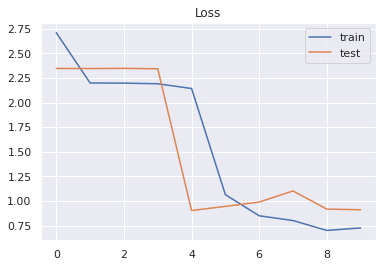

In [ ]:
# create a line graph to show the training and testing loss
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

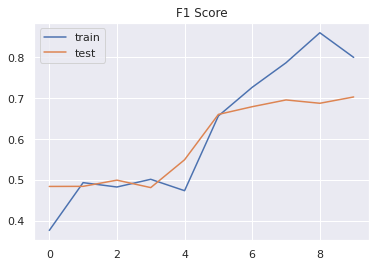

In [ ]:
# create a line graph to show the training and testing accuracy
plt.title('F1 Score')
plt.plot(history.history['f1'], label='train')
plt.plot(history.history['val_f1'], label='test')
plt.legend()
plt.show();

**DistilBert**

In [ ]:
!pip install transformers==2.10.0

     |████████████████████████████████| 665kB 2.8MB/s 
     |████████████████████████████████| 3.8MB 8.9MB/s 
     |████████████████████████████████| 890kB 30.2MB/s 
     |████████████████████████████████| 1.1MB 42.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=ba05a3d73c6670478c8a7624bddc65d4c2060a28b98460444a75b821349f37aa
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 215kB 2.7MB/s 
     |████████████████████████████████| 7.1MB 8.0MB/s 
     |████████████████████████████████| 778kB 42.9MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 1.4MB 39.7MB/s 
     |████████████████████████████████| 317kB 39.6MB/s 
     |████████████████████████████████| 112kB 40.2MB/s 
     |████████████████████████████████| 4.4MB 46.3MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 163kB 39.1MB/s 
     |████████████████████████████████| 112kB 47.9MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 122kB 37.7MB/s 
     |████████████████████████████████| 71kB 6.6MB/s 
     |████████████████████████████████| 71kB 6.9MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=d438a439be4e26c3d7ae3ed90726aac98763bb8b9dec4198449a703cb0c30519
  Stored in dire

In [ ]:
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
tweets_df.drop(['subtask_a', 'subtask_b'], axis = 1, inplace = True, errors = 'ignore')
tweets_df.head()

,tweet,subtask_c
id,,
90194,Go home you re drunk #MAGA #Trump,1
97670,Liberals are all Kookoo,2
52415,was literally just talking about this lol all...,0
13384,Canada doesn t need another CUCK We already ...,1
28414,you are a lying corrupt traitor Nobody wan...,1


In [ ]:
tweets_df.dropna()

,tweet,subtask_c
id,,
90194,Go home you re drunk #MAGA #Trump,1
97670,Liberals are all Kookoo,2
52415,was literally just talking about this lol all...,0
13384,Canada doesn t need another CUCK We already ...,1
28414,you are a lying corrupt traitor Nobody wan...,1
...,...,...
93164,Everything else was ten years ago YOU AR...,1
63482,is advocating for conduct within bounds of Hu...,0
87416,Liars like the Antifa twins you vigorously...,0


In [ ]:
# Create a ClassificationModel
model = ClassificationModel('distilbert', 'distilbert-base-uncased', num_labels=3, use_cuda=False)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
tweets_df['tweet'] = tweets_df['tweet'].str.lower()

In [ ]:
tweets_df.head()

,tweet,subtask_c
id,,
90194,go home you re drunk #maga #trump,1
97670,liberals are all kookoo,2
52415,was literally just talking about this lol all...,0
13384,canada doesn t need another cuck we already ...,1
28414,you are a lying corrupt traitor nobody wan...,1


In [ ]:
xtrain, ytrain, xvalid, yvalid = train_test_split(tweets_df, tweets_df['subtask_c'], test_size=0.2)

In [ ]:
train_df = pd.DataFrame(xtrain)
eval_df = pd.DataFrame(ytrain)

In [ ]:
# Train the model
model.train_model(xtrain)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:282: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [ ]:
from sklearn.metrics import f1_score, accuracy_score


def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='macro')
    
result, model_outputs, wrong_predictions = model.eval_model(eval_df, f1=f1_multiclass, acc=accuracy_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:754: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


In [ ]:
result

{'acc': 0.7164948453608248,
 'eval_loss': 0.6778967537216305,
 'f1': 0.4823036508420124,
 'mcc': 0.4405142129708434}

**Flair**

In [ ]:
!pip install flair

     |████████████████████████████████| 337kB 3.4MB/s 
     |████████████████████████████████| 983kB 12.7MB/s 
     |████████████████████████████████| 276kB 19.2MB/s 
     |████████████████████████████████| 1.1MB 20.1MB/s 
     |████████████████████████████████| 19.7MB 7.6MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 1.1MB 38.4MB/s 
     |████████████████████████████████| 798kB 52.5MB/s 
     |████████████████████████████████| 890kB 43.4MB/s 
     |████████████████████████████████| 3.0MB 45.3MB/s 
  Created wheel for sqlitedict: filename=sqlitedict-1.7.0-cp36-none-any.whl size=14377 sha256=a5c151fb841043171594c504590b3c58ba5e964886f2a758301ef2260e03ee84
  Stored in directory: /root/.cache/pip/wheels/cf/c6/4f/2c64a43f041415eb8b8740bd80e15e92f0d46c5e464d8e4b9b
  Created wheel for segtok: filename=segtok-1.5.10-cp36-none-any.whl size=25021 sha256=f3e7c401efe0b1b76cf851b2b2f4fd0327b7e751700aa2b6d993fe07b88ca0ba
  Stored in directory: /

In [ ]:
import flair
import torch

In [ ]:
data = pd.read_csv("drive/My Drive/OLIDv1.0/olid-training-v1.0.tsv", encoding='latin-1', error_bad_lines=False).sample(frac=1).drop_duplicates()
 
data = tweets_df[['tweet', 'subtask_c']].rename(columns={"tweet":"text", "subtask_c":"labels"})
 
data['labels'] = '__labels__' + data['labels'].astype(str)
 
data.iloc[0:int(len(data)*0.8)].to_csv('train.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.8):int(len(data)*0.9)].to_csv('test.csv', sep='\t', index = False, header = False)
data.iloc[int(len(data)*0.9):].to_csv('dev.csv', sep='\t', index = False, header = False);

b'Skipping line 42: expected 1 fields, saw 2\nSkipping line 113: expected 1 fields, saw 5\nSkipping line 135: expected 1 fields, saw 3\nSkipping line 148: expected 1 fields, saw 3\nSkipping line 176: expected 1 fields, saw 2\nSkipping line 182: expected 1 fields, saw 2\nSkipping line 193: expected 1 fields, saw 3\nSkipping line 229: expected 1 fields, saw 2\nSkipping line 235: expected 1 fields, saw 3\nSkipping line 273: expected 1 fields, saw 2\nSkipping line 298: expected 1 fields, saw 3\nSkipping line 319: expected 1 fields, saw 2\nSkipping line 323: expected 1 fields, saw 2\nSkipping line 349: expected 1 fields, saw 3\nSkipping line 423: expected 1 fields, saw 3\nSkipping line 430: expected 1 fields, saw 2\nSkipping line 449: expected 1 fields, saw 3\nSkipping line 488: expected 1 fields, saw 3\nSkipping line 523: expected 1 fields, saw 3\nSkipping line 539: expected 1 fields, saw 4\nSkipping line 544: expected 1 fields, saw 2\nSkipping line 578: expected 1 fields, saw 3\nSkipping 

In [ ]:
from flair.data import Corpus
from flair.datasets import CSVClassificationCorpus

data_folder = ''
column_name_map = {0: "text", 1: "labels"}

corpus: Corpus = CSVClassificationCorpus(data_folder,
                                         column_name_map,
                                         skip_header=False,
                                         delimiter='\t') 
label_dict = corpus.make_label_dictionary()
len(corpus.dev)

2020-09-30 12:02:38,847 Reading data from .
2020-09-30 12:02:38,849 Train: train.csv
2020-09-30 12:02:38,850 Dev: dev.csv
2020-09-30 12:02:38,851 Test: test.csv
2020-09-30 12:02:38,868 Computing label dictionary. Progress:


100%|██████████| 3488/3488 [00:02<00:00, 1596.01it/s]

2020-09-30 12:02:41,197 [b'__labels__1', b'__labels__2', b'__labels__0']


388

In [ ]:
from flair.data import Corpus
from flair.datasets import TREC_6
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer


# 1. get the corpus
#corpus: Corpus = TREC_6()

# 2. create the label dictionary
label_dict = corpus.make_label_dictionary()

# 3. make a list of word embeddings
word_embeddings = [WordEmbeddings('glove')]

# 4. initialize document embedding by passing list of word embeddings
# Can choose between many RNN types (GRU by default, to change use rnn_type parameter)
document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=256)

# 5. create the text classifier
classifier = TextClassifier(document_embeddings, label_dictionary=label_dict)

# 6. initialize the text classifier trainer
trainer = ModelTrainer(classifier, corpus)

# 7. start the training
trainer.train('resources/taggers/trec',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=10)

2020-09-30 12:07:25,928 Computing label dictionary. Progress:


100%|██████████| 3488/3488 [00:02<00:00, 1373.00it/s]

2020-09-30 12:07:28,989 [b'__labels__1', b'__labels__2', b'__labels__0']


2020-09-30 12:07:29,555 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim.vectors.npy not found in cache, downloading to /tmp/tmpgf3inf0i


100%|██████████| 160000128/160000128 [00:24<00:00, 6440885.28B/s]

2020-09-30 12:07:54,772 copying /tmp/tmpgf3inf0i to cache at /root/.flair/embeddings/glove.gensim.vectors.npy


2020-09-30 12:07:55,141 removing temp file /tmp/tmpgf3inf0i
2020-09-30 12:07:56,284 https://flair.informatik.hu-berlin.de/resources/embeddings/token/glove.gensim not found in cache, downloading to /tmp/tmprhfwy67s


100%|██████████| 21494764/21494764 [00:02<00:00, 10400032.69B/s]

2020-09-30 12:07:59,057 copying /tmp/tmprhfwy67s to cache at /root/.flair/embeddings/glove.gensim
2020-09-30 12:07:59,083 removing temp file /tmp/tmprhfwy67s



/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


2020-09-30 12:08:00,328 ----------------------------------------------------------------------------------------------------
2020-09-30 12:08:00,329 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
    )
    (word_reprojection_map): Linear(in_features=100, out_features=100, bias=True)
    (rnn): GRU(100, 256, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Linear(in_features=256, out_features=3, bias=True)
  (loss_function): CrossEntropyLoss()
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2020-09-30 12:08:00,333 ----------------------------------------------------------------------------------------------------
2020-09-30 12:08:00,338 Corpus: "Corpus: 3100 train + 388 dev + 388 test sentences"
2020-09-30 12:08:00,342 ----------------------------------------------------------------------------------------------------
2020-09-30 12:08:0

{'dev_loss_history': [0.8241798877716064,
  0.8204813599586487,
  0.8082740306854248,
  0.8042293190956116,
  0.7722756862640381,
  0.7741047143936157,
  0.7452269792556763,
  0.7445201873779297,
  0.7217351198196411,
  0.7150142788887024],
 'dev_score_history': [0.6624,
  0.6675,
  0.6881,
  0.6624,
  0.7088,
  0.7216,
  0.7294,
  0.6985,
  0.732,
  0.7242],
 'test_score': 0.6804,
 'train_loss_history': [0.9068694090105823,
  0.8457932208002228,
  0.8241426004576928,
  0.821560414796023,
  0.8041195003027769,
  0.7967620962059375,
  0.7895076446926471,
  0.7850594032056553,
  0.7889399264276642,
  0.7756275064551953]}